# Skeleton notebook for subject-level and group-level statistics
Use this notebook to write the code for subject- and group-level statistics on EEG data

## Setting up Python
First of all, we need to make sure that we are working in the `env` environment.


1. Run `bash env_to_jupyter.sh` from the `EEG` folder if you have not already done so. This will make sure that the `env` environment is available as a kernel in this notebook.

2. Press `Select Kernel`, then `Jupyter kernel...` and select `env`. If `env` does not show up, press the little refresh symbol!

**Note:** You might have to install the Jupyter extension for VScode to be able to select the kernel.

In [1]:
# import libraries
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import mne
from mne.preprocessing import ICA
import pandas as pd
from scipy.stats import zscore
from scipy import stats 

ModuleNotFoundError: No module named 'mne'

In [2]:
def load_epochs(data_path: Path, picks: list[str] = ["eeg"], preload: bool = True) -> list[mne.epochs.EpochsFIF]:
    """
    This function loops over files in data_path and loads all files ending with "-epo.fif",
    while storing the subject name (filename) into metadata.
    """

    epochs = []  # Empty list for storing the epochs

    for f in data_path.iterdir():
        if f.name.endswith("-epo.fif"):
            try:
                tmp_epochs = mne.read_epochs(f, preload=preload)
                tmp_epochs.pick(picks)
                
                if tmp_epochs.metadata is None:
                    n_epochs = len(tmp_epochs)
                    tmp_epochs.metadata = pd.DataFrame(index=np.arange(n_epochs))
                
                tmp_epochs.metadata["subject"] = f.stem.replace("-epo", "")

                epochs.append(tmp_epochs)
            except Exception as e:
                print(f"Error loading {f}: {e}")

    return epochs

In [3]:
data_path = Path("epochs_final/")

all_epochs = load_epochs(data_path, picks=["eeg"])

Reading /work/EEG_Own/CogNeuro2025/EEG_LAB/epochs_final/group19_fw-epo.fif ...
Error loading epochs_final/group19_fw-epo.fif: file '/work/EEG_Own/CogNeuro2025/EEG_LAB/epochs_final/group19_fw-epo.fif' does not start with a file id tag
Reading /work/EEG_Own/CogNeuro2025/EEG_LAB/epochs_final/group0-fw2-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...     696.00 ms
        0 CTF compensation matrices available
Not setting metadata
700 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 0 columns
Reading /work/EEG_Own/CogNeuro2025/EEG_LAB/epochs_final/group1_fw-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...     696.00 ms
        0 CTF compensation matrices available
Not setting metadata
719 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 0 columns
Reading /work/EEG_Own/CogNeuro2025/EEG_LAB/epochs_final/group18_fw-epo.fif ...
    Found the da

In [5]:
import numpy as np
import pandas as pd
from mne.filter import filter_data
from scipy.signal import hilbert

# — subject_ids must match all_epochs in order and length —
subject_ids = ['group20-fw', 'group0_fw', 'group18_fw', 'group19_fw', 'group2_fw', 'group6_fw',
                 'group1_fw', 'group10_fw', 'group9_fw', 'group5_fw']

bands = dict(theta=(4, 7), alpha=(8, 13), beta=(15, 30))
picks = {
    "frontal": ["Fz", "F1", "F2"],
    "parietal": ["Pz", "P3", "P4"],
    "rMFG": ["F4", "FC4", "AF4"],
}

records = []

for epochs, subj_id in zip(all_epochs, subject_ids):
    sfreq = epochs.info["sfreq"]
    data = epochs.get_data()  # shape: (n_epochs, n_ch, n_times)
    ch_names = epochs.ch_names

    for band_name, (fmin, fmax) in bands.items():
        # Band-pass filter with auto filter length
        data_filt = filter_data(
            data, sfreq, l_freq=fmin, h_freq=fmax, filter_length="auto", verbose=False
        )

        # Instantaneous power via analytic signal
        analytic = hilbert(data_filt, axis=-1)
        power_inst = np.abs(analytic) ** 2

        for roi, ch_list in picks.items():
            ch_idxs = [ch_names.index(ch) for ch in ch_list if ch in ch_names]
            if not ch_idxs:
                continue
            val = power_inst[
                :, ch_idxs, :
            ].mean()  # mean across epochs, channels, timepoints
            records.append((subj_id, roi, band_name, val))

# Assemble DataFrame
df_band = pd.DataFrame(records, columns=["subject", "ROI", "band", "power"])

# Show ALL results
print("\n All subject-level band power values:")
print(df_band.to_string(index=False))

# Group-level means
print("\n Group-level mean band power (ROI × band):")
group_means = df_band.groupby(["ROI", "band"])["power"].mean().reset_index()
print(group_means.to_string(index=False))

/tmp/ipykernel_1218/97033664.py:26: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1218/97033664.py:26: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1218/97033664.py:26: RuntimeWarning: filter_length (221) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1218/97033664.py:26: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1218/97033664.py:26: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = fil


 All subject-level band power values:
   subject      ROI  band        power
group20-fw  frontal theta 1.131994e-11
group20-fw parietal theta 1.446535e-11
group20-fw     rMFG theta 9.833234e-12
group20-fw  frontal alpha 9.044196e-12
group20-fw parietal alpha 2.173844e-11
group20-fw     rMFG alpha 1.060904e-11
group20-fw  frontal  beta 6.529104e-12
group20-fw parietal  beta 8.828278e-12
group20-fw     rMFG  beta 6.892018e-12
 group0_fw  frontal theta 1.561646e-11
 group0_fw parietal theta 1.125361e-11
 group0_fw     rMFG theta 1.203528e-11
 group0_fw  frontal alpha 1.885393e-11
 group0_fw parietal alpha 2.645778e-11
 group0_fw     rMFG alpha 1.699439e-11
 group0_fw  frontal  beta 1.680854e-11
 group0_fw parietal  beta 1.609372e-11
 group0_fw     rMFG  beta 2.097892e-11
group18_fw  frontal theta 1.564756e-11
group18_fw parietal theta 9.771362e-12
group18_fw     rMFG theta 1.045777e-11
group18_fw  frontal alpha 2.055917e-11
group18_fw parietal alpha 2.893312e-11
group18_fw     rMFG alpha

In [10]:
import pandas as pd

# Updated H1 with survey data including 10 participants
survey_data = {
    'subject': ['group20-fw', 'group0_fw', 'group18_fw', 'group19_fw', 'group2_fw', 'group6_fw',
                 'group1_fw', 'group10_fw', 'group9_fw', 'group5_fw'],
    'age': [21, 19, 23, 22, 28, 24, 35, 20, 20, 23],
    'gender': ['F', 'F', 'F', 'F', 'M', 'F', 'F', 'M', 'F', 'M'],
    'productive_time': ['morning', 'evening', 'morning', 'morning', 'morning', 
                        'morning', 'evening', 'evening', 'midday', 'midday'],
    'wakeup_time': ['6:30', '7:00', '5:50', '6:30',
        '6:30', '6:45', '6:40', '8:00',
        '7:00', '9:30'],
    'sleep_hours': [7.0, 4.0, 6.0, 6.0, 7.0, 8.0, 7.0, 8.5, 7.0, 7.0],
    'food_intake': ['yes', 'yes', 'no', 'yes', 'maybe', 'yes', 'no', 'yes', 'yes', 'maybe'],
    'stress_level': [6, 8, 6, 7, 7, 3, 9, 3, 3, 3],
    'boredom_trial1': [2, 4, 3, 2, 2, 3, 3, 2, 2, 3],
    'boredom_trial2': [4, 4, 4, 3, 2, 3, 4, 3, 3, 4],
    'boredom_trial3': [5, 5, 5, 4, 2, 5, 4, 3, 3, 5],
}

df_survey = pd.DataFrame(survey_data)

# Exclude specific groups
df_survey = df_survey[~df_survey['subject'].isin(['group2_fw', 'group6_fw'])]

# Convert wakeup_time to hours since midnight for analysis
df_survey['wakeup_hour'] = df_survey['wakeup_time'].apply(lambda x: int(x.split(':')[0]) + int(x.split(':')[1]) / 60)

# Calculate average boredom across trials
df_survey['avg_boredom'] = df_survey[['boredom_trial1', 'boredom_trial2', 'boredom_trial3']].mean(axis=1)

Replacing existing metadata with 1 columns


/tmp/ipykernel_1218/3705418393.py:35: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1218/3705418393.py:35: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1218/3705418393.py:35: RuntimeWarning: filter_length (221) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1218/3705418393.py:35: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1218/3705418393.py:35: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_

Replacing existing metadata with 1 columns


/tmp/ipykernel_1218/3705418393.py:35: RuntimeWarning: filter_length (221) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1218/3705418393.py:35: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1218/3705418393.py:35: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1218/3705418393.py:35: RuntimeWarning: filter_length (221) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1218/3705418393.py:35: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_

Replacing existing metadata with 1 columns


/tmp/ipykernel_1218/3705418393.py:35: RuntimeWarning: filter_length (221) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1218/3705418393.py:35: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1218/3705418393.py:35: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1218/3705418393.py:35: RuntimeWarning: filter_length (221) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1218/3705418393.py:35: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_

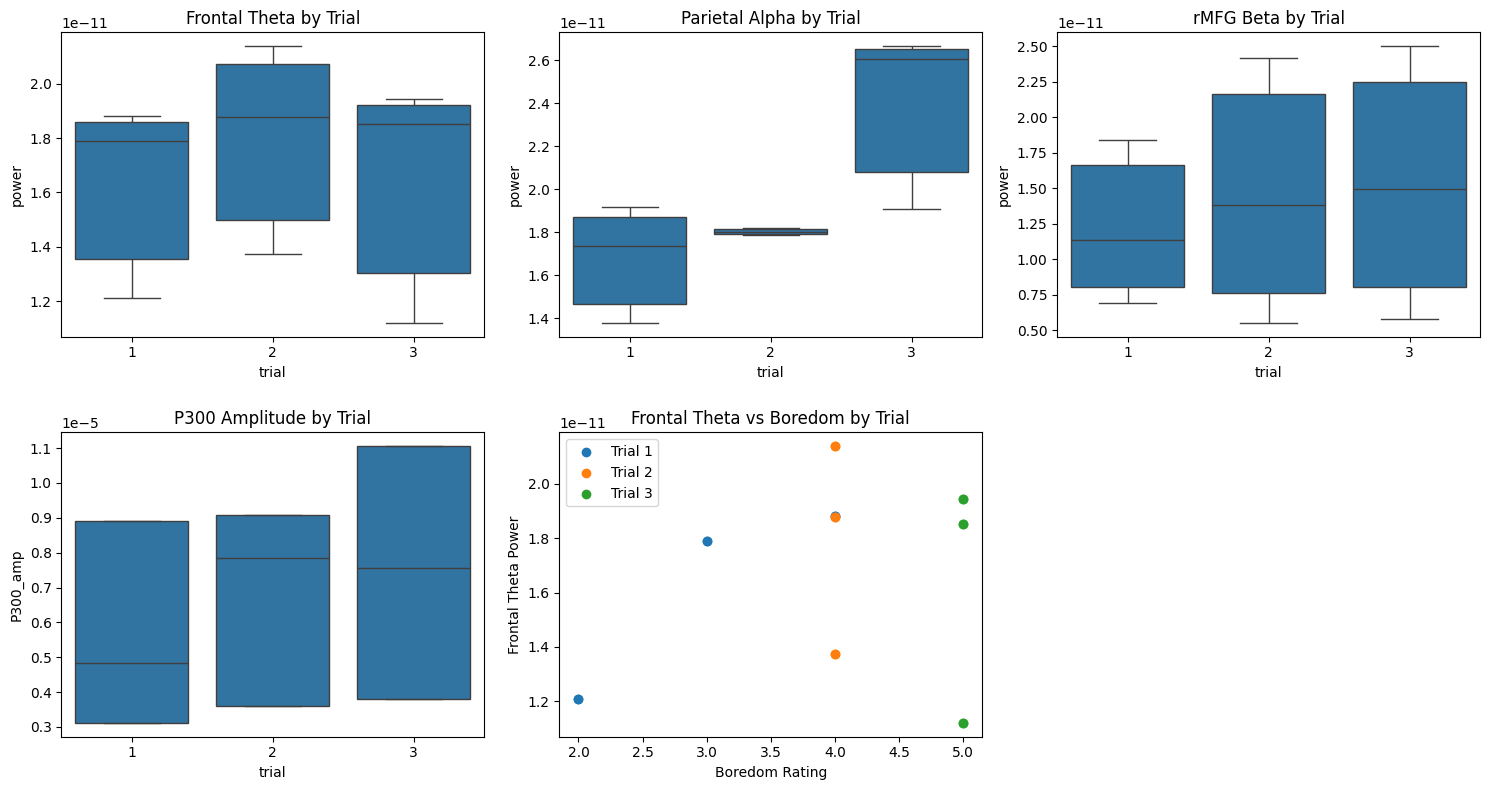

In [11]:
# Trial-by-Trial Analysis of Fatigue Effects

# Modify your existing trial division code to include band power extraction
n_trials = 3
detailed_records = []

for i, (epochs, subj_id) in enumerate(zip(all_epochs, subject_ids)):
    n_events = len(epochs.events)
    trial_len = n_events // n_trials
    
    # Create trial labels
    trial_labels = np.repeat(np.arange(1, n_trials + 1), trial_len)
    if len(trial_labels) < n_events:
        trial_labels = np.concatenate(
            [trial_labels, [n_trials] * (n_events - len(trial_labels))]
        )
    
    # Assign metadata
    metadata = pd.DataFrame({'trial': trial_labels})
    epochs.metadata = metadata
    
    # Process each trial separately
    image_epochs = epochs["Image"].copy()
    
    for trial_num in [1, 2, 3]:
        trial_mask = image_epochs.metadata["trial"] == trial_num
        trial_epochs = image_epochs[trial_mask]
        
        # Skip if no epochs in this trial
        if len(trial_epochs) == 0:
            continue
            
        # Compute band power for this trial
        for band_name, (fmin, fmax) in bands.items():
            data_filt = filter_data(
                trial_epochs.get_data(),
                trial_epochs.info["sfreq"],
                l_freq=fmin,
                h_freq=fmax,
                filter_length="auto",
                verbose=False,
            )
            analytic = hilbert(data_filt, axis=-1)
            power_inst = np.abs(analytic) ** 2
            
            for roi, ch_list in picks.items():
                ch_idx_s = [trial_epochs.ch_names.index(ch) 
                           for ch in ch_list if ch in trial_epochs.ch_names]
                if ch_idx_s:
                    val = power_inst[:, ch_idx_s, :].mean()
                    detailed_records.append((subj_id, trial_num, roi, band_name, val))
        
        # Compute P300 for this trial
        evoked = trial_epochs.average()
        data_pz = evoked.data[evoked.ch_names.index("Pz")]
        times = evoked.times * 1e3
        mask = (times >= 250) & (times <= 500)
        p300_amp = data_pz[mask].max()
        
        # Append P300 amplitude for all band/ROI combinations of this trial
        for record in detailed_records[-len(bands)*len(picks):]:
            detailed_records.append(record + (p300_amp,))

# Create DataFrame from detailed records
columns = ["subject", "trial", "roi", "band", "power", "P300_amp"]
df_trial_detail = pd.DataFrame(detailed_records, columns=columns)

# Merge with survey data
df_trial_full = pd.merge(df_trial_detail, df_survey, on='subject')

# Analyze changes across trials
plt.figure(figsize=(15, 8))

# Frontal theta by trial
plt.subplot(2, 3, 1)
sns.boxplot(x='trial', y='power', 
            data=df_trial_full[(df_trial_full['roi']=='frontal') & 
                              (df_trial_full['band']=='theta')])
plt.title('Frontal Theta by Trial')

# Parietal alpha by trial
plt.subplot(2, 3, 2)
sns.boxplot(x='trial', y='power', 
            data=df_trial_full[(df_trial_full['roi']=='parietal') & 
                              (df_trial_full['band']=='alpha')])
plt.title('Parietal Alpha by Trial')

# rMFG beta by trial
plt.subplot(2, 3, 3)
sns.boxplot(x='trial', y='power', 
            data=df_trial_full[(df_trial_full['roi']=='rMFG') & 
                              (df_trial_full['band']=='beta')])
plt.title('rMFG Beta by Trial')

# P300 amplitude by trial
plt.subplot(2, 3, 4)
sns.boxplot(x='trial', y='P300_amp', data=df_trial_full)
plt.title('P300 Amplitude by Trial')

# Frontal theta vs boredom by trial
plt.subplot(2, 3, 5)
for trial in [1, 2, 3]:
    subset = df_trial_full[(df_trial_full['roi']=='frontal') & 
                          (df_trial_full['band']=='theta') & 
                          (df_trial_full['trial']==trial)]
    plt.scatter(subset[f'boredom_trial{trial}'], subset['power'], 
               label=f'Trial {trial}')
plt.legend()
plt.xlabel('Boredom Rating')
plt.ylabel('Frontal Theta Power')
plt.title('Frontal Theta vs Boredom by Trial')

plt.tight_layout()
plt.show()

In [30]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# For theta power
theta_model = smf.mixedlm("power ~ event", data=df_theta, groups=df_theta["subject"]).fit()
print(theta_model.summary())

# For alpha power
alpha_model = smf.mixedlm("power ~ event", data=df_alpha, groups=df_alpha["subject"]).fit()
print(alpha_model.summary())

# For beta power
beta_model = smf.mixedlm("power ~ event", data=df_beta, groups=df_beta["subject"]).fit()
print(beta_model.summary())

from scipy.stats import pearsonr

def compute_band_corr_with_p(band, var):
    band_means = df_event_full[df_event_full['band'] == band].groupby('subject')['power'].mean()
    var_means = df_event_full.groupby('subject')[var].mean()
    corr, pval = pearsonr(band_means, var_means)
    return corr, pval

# Example usage
theta_stress_corr, theta_stress_p = compute_band_corr_with_p('theta', 'stress_level')
print(f"Theta-Stress correlation: r={theta_stress_corr:.2f}, p={theta_stress_p:.4f}")

# Prepare subject-level data
df_subj = df_event_full.groupby('subject').agg({
    'P300_amp': 'mean',
    'stress_level': 'mean',
    'avg_boredom': 'mean',
    'sleep_hours': 'mean',
    'wakeup_hour': 'mean'
}).reset_index()

# Get mean power for each band and ROI combination
df_power = df_event_full.groupby(['subject', 'roi', 'band'])['power'].mean().reset_index()

# Merge with subject data
df_analysis = pd.merge(df_power, df_subj, on='subject')

# Now run regression for theta in frontal region
theta_lm = smf.ols(
    "power ~ stress_level + avg_boredom + sleep_hours + wakeup_hour",
    data=df_analysis[(df_analysis['roi'] == 'frontal') & (df_analysis['band'] == 'theta')]
).fit()
print(theta_lm.summary())

# For alpha in parietal region
alpha_lm = smf.ols(
    "power ~ stress_level + avg_boredom + sleep_hours + wakeup_hour",
    data=df_analysis[(df_analysis['roi'] == 'parietal') & (df_analysis['band'] == 'alpha')]
).fit()
print(alpha_lm.summary())

# For beta in rMFG region
beta_lm = smf.ols(
    "power ~ stress_level + avg_boredom + sleep_hours + wakeup_hour",
    data=df_analysis[(df_analysis['roi'] == 'rMFG') & (df_analysis['band'] == 'beta')]
).fit()
print(beta_lm.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: power     
No. Observations: 2142    Method:             REML      
No. Groups:       3       Scale:              0.0000    
Min. group size:  700     Log-Likelihood:     51319.4537
Max. group size:  723     Converged:          Yes       
Mean group size:  714.0                                 
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   0.000     0.000  9.294  0.000   0.000   0.000
event       0.000     0.000  1.456  0.145  -0.000   0.000
Group Var   0.000     0.000                              

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: power     
No. Observations: 2142    Method:             REML      
No. Groups:       3       Scale:              0.0000    
Min. group size:  700     Log-Likelihood:   

/work/EEG_Own/CogNeuro2025/EEG_LAB/env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/work/EEG_Own/CogNeuro2025/EEG_LAB/env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/work/EEG_Own/CogNeuro2025/EEG_LAB/env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/work/EEG_Own/CogNeuro2025/EEG_LAB/env/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/work/EEG_Own/CogNeuro2025/

<Figure size 1600x1200 with 0 Axes>

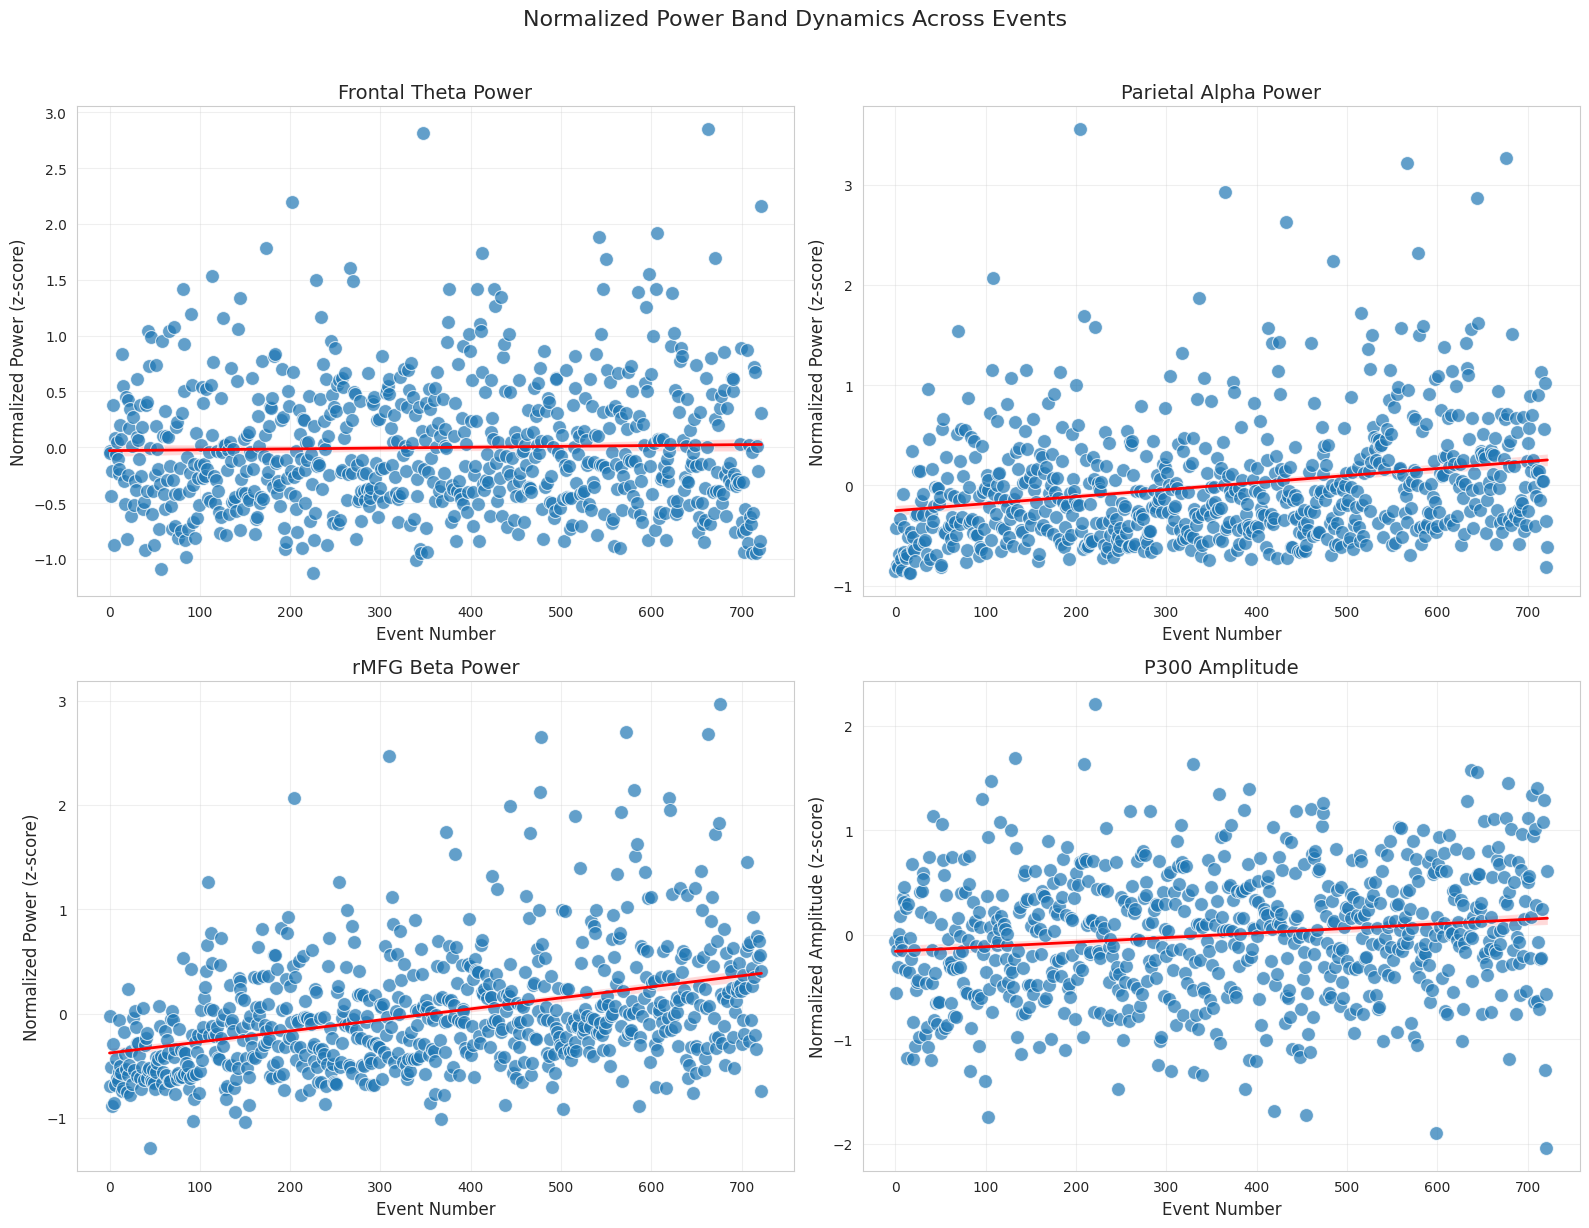

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import hilbert
from mne.filter import filter_data
from scipy.stats import zscore

# === EEG frequency bands and ROIs ===
bands = dict(theta=(4, 7), alpha=(8, 13), beta=(15, 30))
picks = {
    "frontal": ["Fz", "F1", "F2"],      # Theta band
    "parietal": ["Pz", "P3", "P4"],     # Alpha band
    "rMFG": ["F4", "FC4", "AF4"]        # Beta band
}
p300_channel = 'Pz'
p300_window = (0.3, 0.6)  # In seconds

# === Feature extraction loop ===
detailed_records = []

for subj_epochs in all_epochs:
    subject = subj_epochs.filename.split('/')[-1].replace('-epo.fif', '')
    sfreq = subj_epochs.info['sfreq']
    tmin = subj_epochs.times[0]
    p300_start_idx = int((p300_window[0] - tmin) * sfreq)
    p300_end_idx = int((p300_window[1] - tmin) * sfreq)

    for i, event in enumerate(subj_epochs.events):
        for roi_name, roi_channels in picks.items():
            available_channels = [ch for ch in roi_channels if ch in subj_epochs.ch_names]
            if not available_channels:
                continue

            for band_name, (fmin, fmax) in bands.items():
                try:
                    data = subj_epochs.copy().pick(available_channels).get_data()[i]
                    filtered = filter_data(data, sfreq=sfreq, l_freq=fmin, h_freq=fmax, verbose=False)
                    power = np.mean(np.abs(hilbert(filtered, axis=1)) ** 2)
                    
                    ch_data = subj_epochs.copy().pick([p300_channel]).get_data()[i][0]
                    P300_amp = np.max(ch_data[p300_start_idx:p300_end_idx])
                    
                    detailed_records.append([subject, i, roi_name, band_name, power, P300_amp])
                except:
                    continue

# === Create dataframe and filter bands ===
columns = ["subject", "event", "roi", "band", "power", "P300_amp"]
df = pd.DataFrame(detailed_records, columns=columns)

# Get specific bands and ROIs we want to plot
df_theta = df[(df['roi'] == 'frontal') & (df['band'] == 'theta')].copy()
df_alpha = df[(df['roi'] == 'parietal') & (df['band'] == 'alpha')].copy()
df_beta = df[(df['roi'] == 'rMFG') & (df['band'] == 'beta')].copy()
df_p300 = df[['subject', 'event', 'P300_amp']].copy()

# Normalize the power values within each subject
for band_df in [df_theta, df_alpha, df_beta, df_p300]:
    if 'power' in band_df.columns:
        band_df.loc[:, 'power_norm'] = band_df.groupby('subject')['power'].transform(
            lambda x: zscore(x, ddof=1))
    else:
        band_df.loc[:, 'P300_norm'] = band_df.groupby('subject')['P300_amp'].transform(
            lambda x: zscore(x, ddof=1))

# Compute event averages
theta_avg = df_theta.groupby('event')['power_norm'].mean().reset_index()
alpha_avg = df_alpha.groupby('event')['power_norm'].mean().reset_index()
beta_avg = df_beta.groupby('event')['power_norm'].mean().reset_index()
p300_avg = df_p300.groupby('event')['P300_norm'].mean().reset_index()

# === Create optimized plots ===
plt.figure(figsize=(16, 12))
sns.set_style("whitegrid")
plt.suptitle("Normalized Power Band Dynamics Across Events", y=1.02, fontsize=16)

# Define colors
regression_color = '#1f77b4'  # Blue
ci_color = 'red'         # Red

# === Create optimized plots ===
plt.figure(figsize=(16, 12))
sns.set_style("whitegrid")
plt.suptitle("Normalized Power Band Dynamics Across Events", y=1.02, fontsize=16)

# Define colors
regression_color = '#1f77b4'  # Blue for scatter points
line_color = 'red'            # Red for regression line

# 1) Theta Power
plt.subplot(2, 2, 1)
sns.regplot(
    x='event', y='power_norm', data=theta_avg,
    scatter_kws={'s': 100, 'alpha': 0.7, 'color': regression_color},
    line_kws={'color': line_color, 'lw': 2},
    ci=80, scatter=False
)
sns.scatterplot(x='event', y='power_norm', data=theta_avg,
                color=regression_color, s=100, alpha=0.7)
plt.title('Frontal Theta Power', fontsize=14)
plt.xlabel('Event Number', fontsize=12)
plt.ylabel('Normalized Power (z-score)', fontsize=12)
plt.grid(True, alpha=0.3)

# 2) Alpha Power
plt.subplot(2, 2, 2)
sns.regplot(
    x='event', y='power_norm', data=alpha_avg,
    scatter_kws={'s': 100, 'alpha': 0.7, 'color': regression_color},
    line_kws={'color': line_color, 'lw': 2},
    ci=80, scatter=False
)
sns.scatterplot(x='event', y='power_norm', data=alpha_avg,
                color=regression_color, s=100, alpha=0.7)
plt.title('Parietal Alpha Power', fontsize=14)
plt.xlabel('Event Number', fontsize=12)
plt.ylabel('Normalized Power (z-score)', fontsize=12)
plt.grid(True, alpha=0.3)

# 3) Beta Power
plt.subplot(2, 2, 3)
sns.regplot(
    x='event', y='power_norm', data=beta_avg,
    scatter_kws={'s': 100, 'alpha': 0.7, 'color': regression_color},
    line_kws={'color': line_color, 'lw': 2},
    ci=80, scatter=False
)
sns.scatterplot(x='event', y='power_norm', data=beta_avg,
                color=regression_color, s=100, alpha=0.7)
plt.title('rMFG Beta Power', fontsize=14)
plt.xlabel('Event Number', fontsize=12)
plt.ylabel('Normalized Power (z-score)', fontsize=12)
plt.grid(True, alpha=0.3)

# 4) P300 Amplitude
plt.subplot(2, 2, 4)
sns.regplot(
    x='event', y='P300_norm', data=p300_avg,
    scatter_kws={'s': 100, 'alpha': 0.7, 'color': regression_color},
    line_kws={'color': line_color, 'lw': 2},
    ci=80, scatter=False
)
sns.scatterplot(x='event', y='P300_norm', data=p300_avg,
                color=regression_color, s=100, alpha=0.7)
plt.title('P300 Amplitude', fontsize=14)
plt.xlabel('Event Number', fontsize=12)
plt.ylabel('Normalized Amplitude (z-score)', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


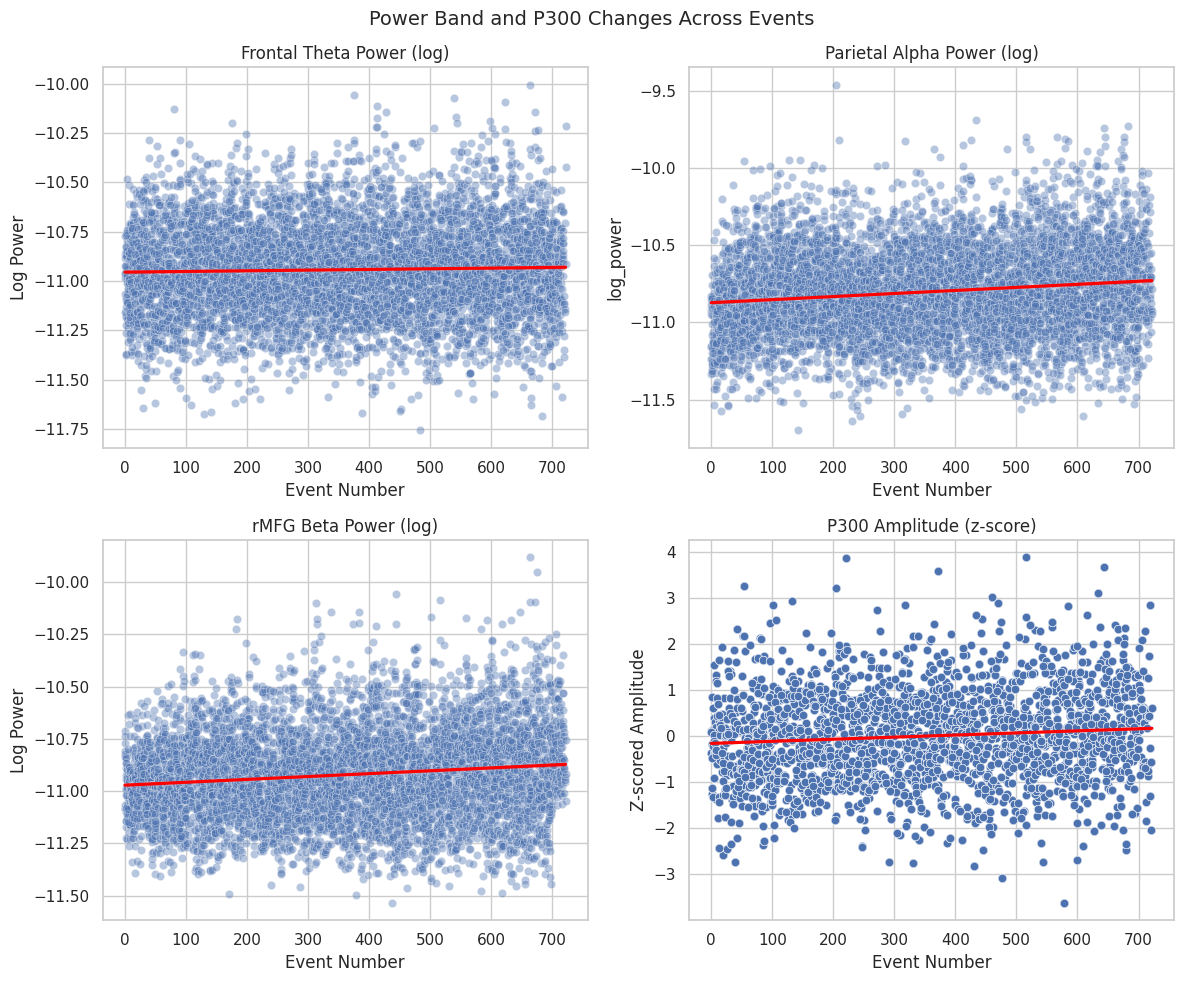


=== Mixed Effects Models ===

--- Theta ---
           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  log_power
No. Observations:  6426     Method:              REML     
No. Groups:        3        Scale:               0.0554   
Min. group size:   2100     Log-Likelihood:      161.2465 
Max. group size:   2169     Converged:           Yes      
Mean group size:   2142.0                                 
----------------------------------------------------------
           Coef.  Std.Err.     z     P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept -10.955    0.010 -1117.674 0.000 -10.975 -10.936
event       0.000    0.000     2.371 0.018   0.000   0.000
Group Var   0.000    0.001                                



/work/EEG_Own/CogNeuro2025/EEG_LAB/env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/work/EEG_Own/CogNeuro2025/EEG_LAB/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/work/EEG_Own/CogNeuro2025/EEG_LAB/env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/work/EEG_Own/CogNeuro2025/EEG_LAB/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/work/EEG_Own/CogNeuro2025/EEG_LAB/env/lib/python3.12/site-packages/


--- Alpha ---
           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: log_power
No. Observations:   6426    Method:             REML     
No. Groups:         3       Scale:              0.0744   
Min. group size:    2100    Log-Likelihood:     -790.9366
Max. group size:    2169    Converged:          No       
Mean group size:    2142.0                               
---------------------------------------------------------
           Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept -10.870    0.068 -160.034 0.000 -11.003 -10.736
event       0.000    0.000   11.352 0.000   0.000   0.000
Group Var   0.014    0.059                               


--- Beta ---
           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: log_power
No. Observations:   6426    Method:             REML     
No. Groups:         3       Scale:              0.0267   
Mi

/work/EEG_Own/CogNeuro2025/EEG_LAB/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/work/EEG_Own/CogNeuro2025/EEG_LAB/env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/work/EEG_Own/CogNeuro2025/EEG_LAB/env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Load your data
# df = pd.read_csv('your_file.csv')  # Uncomment if loading from file

# Log-transform power for normalization (since power values are very small)
df['log_power'] = df['power'].apply(lambda x: np.log10(x + 1e-12))

# P300 doesn't need log, but normalize it (z-score per subject if needed)
df['P300_z'] = df.groupby('subject')['P300_amp'].transform(lambda x: (x - x.mean()) / x.std())

# === PLOTS ===
plt.figure(figsize=(12, 10))

# Plot theta
plt.subplot(2, 2, 1)
theta_df = df[df['band'] == 'theta']
sns.scatterplot(data=theta_df, x='event', y='log_power', alpha=0.4)
sns.regplot(data=theta_df, x='event', y='log_power', scatter=False, color='red')
plt.title('Frontal Theta Power (log)')
plt.xlabel('Event Number')
plt.ylabel('Log Power')

# Plot alpha
plt.subplot(2, 2, 2)
alpha_df = df[df['band'] == 'alpha']
sns.scatterplot(data=alpha_df, x='event', y='log_power', alpha=0.4)
sns.regplot(data=alpha_df, x='event', y='log_power', scatter=False, color='red')
plt.title('Parietal Alpha Power (log)')
plt.xlabel('Event Number')

# Plot beta
plt.subplot(2, 2, 3)
beta_df = df[df['band'] == 'beta']
sns.scatterplot(data=beta_df, x='event', y='log_power', alpha=0.4)
sns.regplot(data=beta_df, x='event', y='log_power', scatter=False, color='red')
plt.title('rMFG Beta Power (log)')
plt.xlabel('Event Number')
plt.ylabel('Log Power')

# Plot P300
plt.subplot(2, 2, 4)
sns.scatterplot(data=df, x='event', y='P300_z', alpha=0.4)
sns.regplot(data=df, x='event', y='P300_z', scatter=False, color='red')
plt.title('P300 Amplitude (z-score)')
plt.xlabel('Event Number')
plt.ylabel('Z-scored Amplitude')

plt.suptitle("Power Band and P300 Changes Across Events", fontsize=14)
plt.tight_layout()
plt.show()

# === STATISTICAL MODELS ===
print("\n=== Mixed Effects Models ===")
from statsmodels.formula.api import mixedlm

# Theta
theta_model = mixedlm("log_power ~ event", theta_df, groups=theta_df["subject"])
theta_result = theta_model.fit()
print("\n--- Theta ---\n", theta_result.summary())

# Alpha
alpha_model = mixedlm("log_power ~ event", alpha_df, groups=alpha_df["subject"])
alpha_result = alpha_model.fit()
print("\n--- Alpha ---\n", alpha_result.summary())

# Beta
beta_model = mixedlm("log_power ~ event", beta_df, groups=beta_df["subject"])
beta_result = beta_model.fit()
print("\n--- Beta ---\n", beta_result.summary())

# P300
p300_model = mixedlm("P300_z ~ event", df, groups=df["subject"])
p300_result = p300_model.fit()
print("\n--- P300 ---\n", p300_result.summary())


In [33]:
print("Columns:", df.columns.tolist())
print("\nSample data:")
print(df.head())


Columns: ['subject', 'event', 'roi', 'band', 'power', 'P300_amp']

Sample data:
      subject  event       roi   band         power  P300_amp
0  group0-fw2      0   frontal  theta  1.273735e-11  0.000013
1  group0-fw2      0   frontal  alpha  1.038888e-11  0.000013
2  group0-fw2      0   frontal   beta  7.301179e-12  0.000013
3  group0-fw2      0  parietal  theta  7.624887e-12  0.000013
4  group0-fw2      0  parietal  alpha  5.922074e-12  0.000013


In [31]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Assign band label
df_theta['band'] = 'theta'
df_alpha['band'] = 'alpha'
df_beta['band'] = 'beta'
df_all = pd.concat([df_theta, df_alpha, df_beta], ignore_index=True)

# Ensure proper types
df_all['subject'] = df_all['subject'].astype(str)
df_all['event'] = df_all['event'].astype(int)
df_all['band'] = df_all['band'].astype('category')
df_all['roi'] = df_all['roi'].astype('category')

# Analyze each band separately
results = {}

for band in ['theta', 'alpha', 'beta']:
    df_band = df_all[df_all['band'] == band].copy()

    # Mixed-effects model: power ~ event + (1|subject)
    model = smf.mixedlm("power_norm ~ event", df_band, groups=df_band["subject"])
    fit = model.fit()
    results[band] = fit

    print(f"\n=== {band.upper()} Band ===")
    print(fit.summary())


/work/EEG_Own/CogNeuro2025/EEG_LAB/env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/work/EEG_Own/CogNeuro2025/EEG_LAB/env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/work/EEG_Own/CogNeuro2025/EEG_LAB/env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/work/EEG_Own/CogNeuro2025/EEG_LAB/env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/work/EEG_Own/CogNeuro2025/EEG_LAB/env/lib/python3.12/site-


=== THETA Band ===
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: power_norm
No. Observations: 2142    Method:             REML      
No. Groups:       3       Scale:              0.9991    
Min. group size:  700     Log-Likelihood:     -3048.5824
Max. group size:  723     Converged:          Yes       
Mean group size:  714.0                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -0.035    0.043 -0.816 0.414 -0.120  0.049
event          0.000    0.000  0.943 0.346 -0.000  0.000
Group Var      0.000                                    


=== ALPHA Band ===
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: power_norm
No. Observations: 2142    Method:             REML      
No. Groups:       3       Scale:              0.9779    
Min. group

/work/EEG_Own/CogNeuro2025/EEG_LAB/env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/work/EEG_Own/CogNeuro2025/EEG_LAB/env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Processing subject: group0-fw2
Partial channels for frontal in group0-fw2: using ['Fz']
Partial channels for rMFG in group0-fw2: using ['F4']
Partial channels for frontal in group0-fw2: using ['Fz']
Partial channels for rMFG in group0-fw2: using ['F4']
Partial channels for frontal in group0-fw2: using ['Fz']
Partial channels for rMFG in group0-fw2: using ['F4']
Partial channels for frontal in group0-fw2: using ['Fz']
Partial channels for rMFG in group0-fw2: using ['F4']
Partial channels for frontal in group0-fw2: using ['Fz']
Partial channels for rMFG in group0-fw2: using ['F4']
Partial channels for frontal in group0-fw2: using ['Fz']
Partial channels for rMFG in group0-fw2: using ['F4']
Partial channels for frontal in group0-fw2: using ['Fz']
Partial channels for rMFG in group0-fw2: using ['F4']
Partial channels for frontal in group0-fw2: using ['Fz']
Partial channels for rMFG in group0-fw2: using ['F4']
Partial channels for frontal in group0-fw2: using ['Fz']
Partial channels for rMF

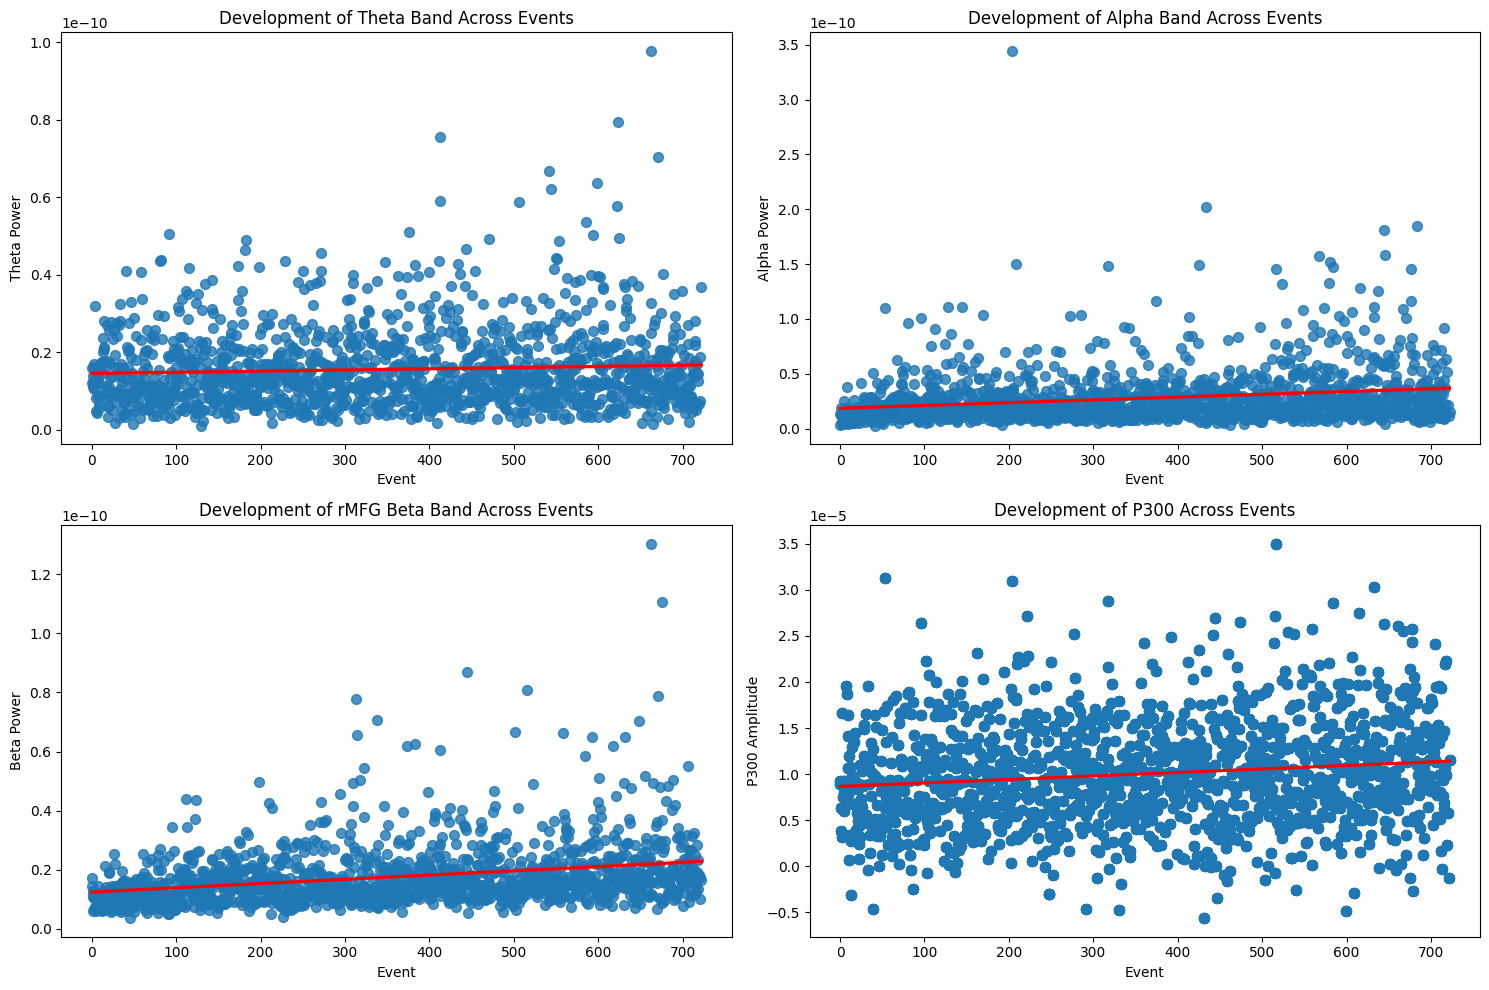

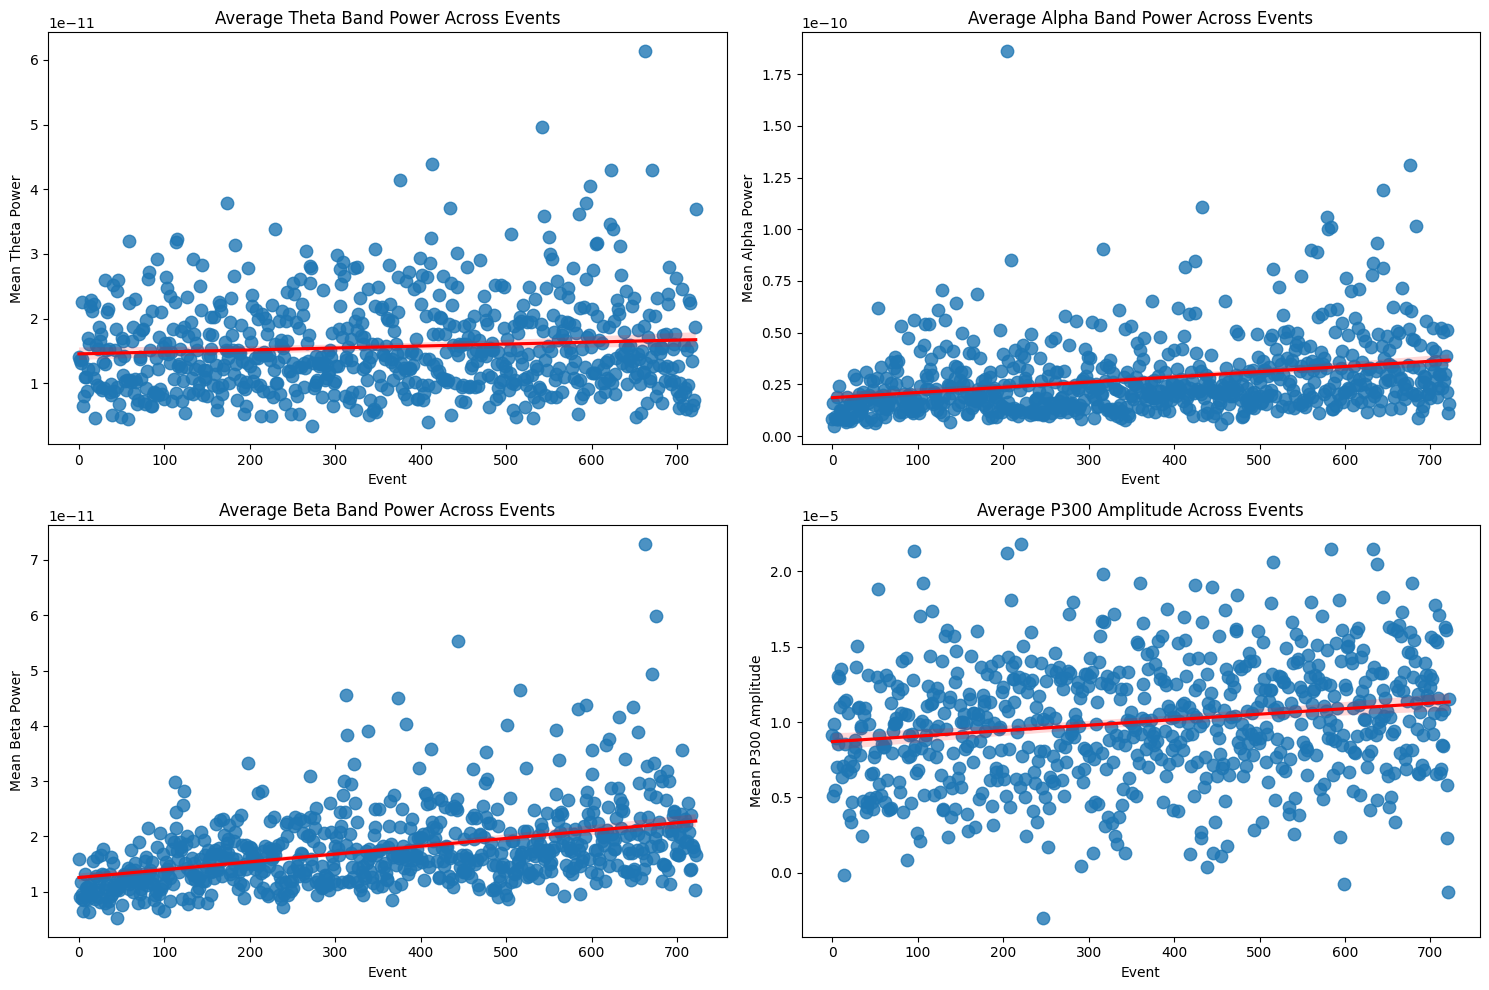

In [18]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import hilbert
from mne.filter import filter_data

# === Preprocessing survey data ===

# Exclude problematic groups
df_survey = df_survey[~df_survey['subject'].isin(['group2_fw', 'group6_fw'])]

# Extract hour from wakeup time string
df_survey['wakeup_hour'] = df_survey['wakeup_time'].apply(lambda x: int(x.split(':')[0]) + int(x.split(':')[1]) / 60)

# Compute average boredom
df_survey['avg_boredom'] = df_survey[['boredom_trial1', 'boredom_trial2', 'boredom_trial3']].mean(axis=1)

# === EEG frequency bands and ROIs ===

bands = dict(theta=(4, 7), alpha=(8, 13), beta=(15, 30))
picks = {
    "frontal": ["Fz", "F1", "F2"],      # Theta band
    "parietal": ["Pz", "P3", "P4"],     # Alpha band
    "rMFG": ["F4", "FC4", "AF4"]        # Beta band
}
p300_channel = 'Pz'
p300_window = (0.3, 0.6)  # In seconds

# === Feature extraction loop ===

detailed_records = []

for subj_epochs in all_epochs:
    # Get subject ID from filename (since metadata might not be properly set)
    subject = subj_epochs.filename.split('/')[-1].replace('-epo.fif', '')
    print(f"Processing subject: {subject}")
    
    sfreq = subj_epochs.info['sfreq']
    tmin = subj_epochs.times[0]
    p300_start_idx = int((p300_window[0] - tmin) * sfreq)
    p300_end_idx = int((p300_window[1] - tmin) * sfreq)

    for i, event in enumerate(subj_epochs.events):
        for roi_name, roi_channels in picks.items():
            # Get available channels for this ROI
            available_channels = [ch for ch in roi_channels if ch in subj_epochs.ch_names]
            
            if not available_channels:
                print(f"Skipping ROI {roi_name} for subject {subject} — no available channels")
                continue
            elif len(available_channels) < len(roi_channels):
                print(f"Partial channels for {roi_name} in {subject}: using {available_channels}")

            for band_name, (fmin, fmax) in bands.items():
                try:
                    # Get data for this event and ROI channels
                    data = subj_epochs.copy().pick(available_channels).get_data()[i]
                    
                    # Filter and compute power
                    filtered = filter_data(data, sfreq=sfreq, l_freq=fmin, h_freq=fmax, filter_length='auto', verbose=False)
                    power = np.mean(np.abs(hilbert(filtered, axis=1)) ** 2)

                    # Get P300 amplitude
                    ch_data = subj_epochs.copy().pick([p300_channel]).get_data()[i][0]
                    P300_amp = np.max(ch_data[p300_start_idx:p300_end_idx])

                    detailed_records.append([subject, i, roi_name, band_name, power, P300_amp])
                except Exception as e:
                    print(f"Error in {subject} event {i} {roi_name}-{band_name}: {e}")

# === Combine and analyze results ===

columns = ["subject", "event", "roi", "band", "power", "P300_amp"]
df_event_detail = pd.DataFrame(detailed_records, columns=columns)
df_event_full = pd.merge(df_event_detail, df_survey, on='subject')

# Correlation analysis
def compute_band_corr(band, var):
    return df_event_full[df_event_full['band'] == band].groupby('subject')['power'].mean().corr(df_event_full.groupby('subject')[var].mean())

print("Correlation with Stress Level:")
print(f"Theta: {compute_band_corr('theta', 'stress_level')}")
print(f"Alpha: {compute_band_corr('alpha', 'stress_level')}")
print(f"Beta: {compute_band_corr('beta', 'stress_level')}")

print("\nCorrelation with Average Boredom:")
print(f"Theta: {compute_band_corr('theta', 'avg_boredom')}")
print(f"Alpha: {compute_band_corr('alpha', 'avg_boredom')}")
print(f"Beta: {compute_band_corr('beta', 'avg_boredom')}")

print("\nCorrelation with Sleep Hours:")
print(f"Theta: {compute_band_corr('theta', 'sleep_hours')}")
print(f"Alpha: {compute_band_corr('alpha', 'sleep_hours')}")
print(f"Beta: {compute_band_corr('beta', 'sleep_hours')}")

p300_corr_wakeup_hour = df_event_full.groupby('subject')['P300_amp'].mean().corr(df_event_full.groupby('subject')['wakeup_hour'].mean())
p300_corr_sleep_hours = df_event_full.groupby('subject')['P300_amp'].mean().corr(df_event_full.groupby('subject')['sleep_hours'].mean())

print("\nCorrelation of P300 Amplitude with Circadian Rhythm:")
print(f"Wakeup Hour: {p300_corr_wakeup_hour}")
print(f"Sleep Hours: {p300_corr_sleep_hours}")

# Compute average power per event for each condition
df_theta = df_event_full[(df_event_full['roi'] == 'frontal') & (df_event_full['band'] == 'theta')]
df_alpha = df_event_full[(df_event_full['roi'] == 'parietal') & (df_event_full['band'] == 'alpha')]
df_beta = df_event_full[(df_event_full['roi'] == 'rMFG') & (df_event_full['band'] == 'beta')]

df_theta_avg = df_theta.groupby('event', as_index=False)['power'].mean()
df_alpha_avg = df_alpha.groupby('event', as_index=False)['power'].mean()
df_beta_avg = df_beta.groupby('event', as_index=False)['power'].mean()
df_p300_avg = df_event_full.groupby('event', as_index=False)['P300_amp'].mean()

# === Plot results ===

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.regplot(x='event', y='power', data=df_theta, scatter_kws={'s': 50}, line_kws={"color": "red"})
plt.title('Development of Theta Band Across Events')
plt.xlabel('Event')
plt.ylabel('Theta Power')

plt.subplot(2, 2, 2)
sns.regplot(x='event', y='power', data=df_alpha, scatter_kws={'s': 50}, line_kws={"color": "red"})
plt.title('Development of Alpha Band Across Events')
plt.xlabel('Event')
plt.ylabel('Alpha Power')

plt.subplot(2, 2, 3)
sns.regplot(x='event', y='power', data=df_beta, scatter_kws={'s': 50}, line_kws={"color": "red"})
plt.title('Development of rMFG Beta Band Across Events')
plt.xlabel('Event')
plt.ylabel('Beta Power')

plt.subplot(2, 2, 4)
sns.regplot(x='event', y='P300_amp', data=df_event_full, scatter_kws={'s': 50}, line_kws={"color": "red"})
plt.title('Development of P300 Across Events')
plt.xlabel('Event')
plt.ylabel('P300 Amplitude')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))

# 1) Theta band
plt.subplot(2, 2, 1)
sns.regplot(x='event', y='power', data=df_theta_avg, scatter_kws={'s': 80}, line_kws={"color": "red"})
plt.title('Average Theta Band Power Across Events')
plt.xlabel('Event')
plt.ylabel('Mean Theta Power')

# 2) Alpha band
plt.subplot(2, 2, 2)
sns.regplot(x='event', y='power', data=df_alpha_avg, scatter_kws={'s': 80}, line_kws={"color": "red"})
plt.title('Average Alpha Band Power Across Events')
plt.xlabel('Event')
plt.ylabel('Mean Alpha Power')

# 3) Beta band
plt.subplot(2, 2, 3)
sns.regplot(x='event', y='power', data=df_beta_avg, scatter_kws={'s': 80}, line_kws={"color": "red"})
plt.title('Average Beta Band Power Across Events')
plt.xlabel('Event')
plt.ylabel('Mean Beta Power')

# 4) P300 Amplitude
plt.subplot(2, 2, 4)
sns.regplot(x='event', y='P300_amp', data=df_p300_avg, scatter_kws={'s': 80}, line_kws={"color": "red"})
plt.title('Average P300 Amplitude Across Events')
plt.xlabel('Event')
plt.ylabel('Mean P300 Amplitude')

plt.tight_layout()
plt.show()

/tmp/ipykernel_1288/2407147979.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


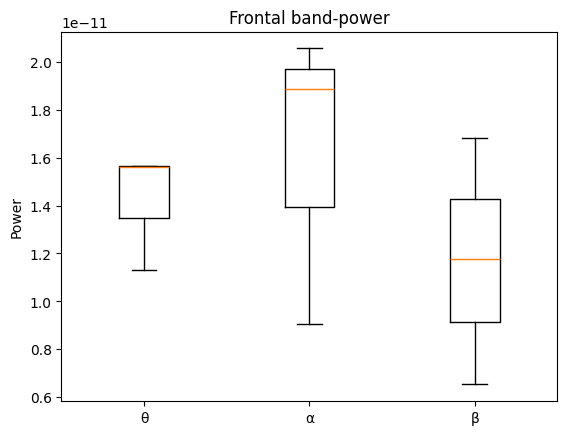

/tmp/ipykernel_1288/2407147979.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


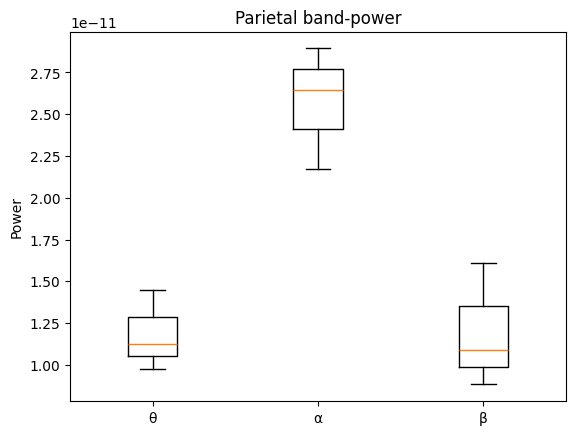

/tmp/ipykernel_1288/2407147979.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


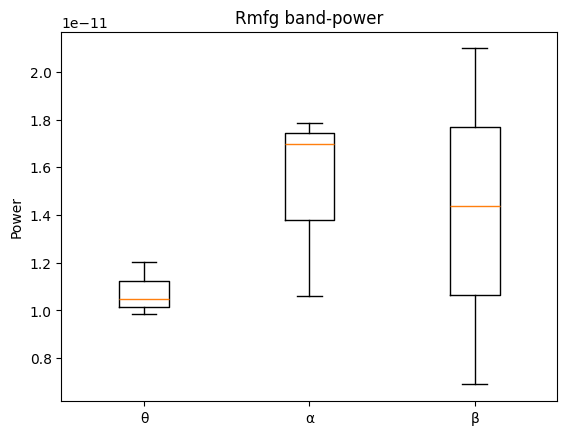

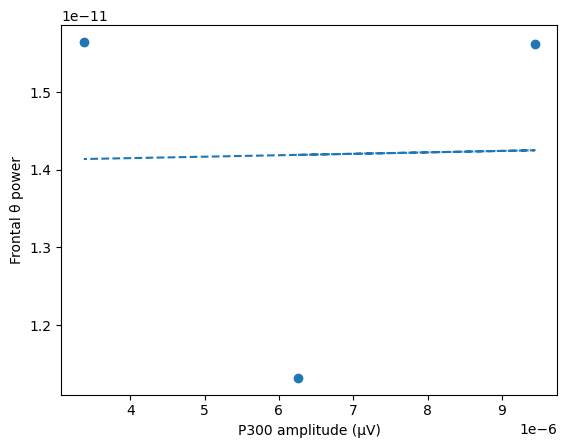

In [11]:
## 07‑Visualization of effects

import matplotlib.pyplot as plt

# A) Boxplots of power by ROI & band
for roi in df["ROI"].unique():
    fig, ax = plt.subplots()
    roidf = df[df.ROI == roi]
    ax.boxplot(
        [roidf[roidf.band == b]["power"] for b in ["theta", "alpha", "beta"]],
        labels=["θ", "α", "β"],
    )
    ax.set_title(f"{roi.capitalize()} band‐power")
    ax.set_ylabel("Power")
    plt.show()

# B) Scatter P300_amp vs. frontal‐theta
sub = df[(df.band == "theta") & (df.ROI == "frontal")]
fig, ax = plt.subplots()
ax.scatter(sub["P300_amp"], sub["power"])
m, b = np.polyfit(sub["P300_amp"], sub["power"], 1)
ax.plot(sub["P300_amp"], m * sub["P300_amp"] + b, linestyle="--")
ax.set_xlabel("P300 amplitude (µV)")
ax.set_ylabel("Frontal θ power")
plt.show()

In [12]:
# Dividing into 3 trials
import numpy as np
import pandas as pd

n_trials = 3

for i, epochs in enumerate(all_epochs):
    n_events = len(epochs.events)  # use per-subject event count
    trial_len = n_events // n_trials

    # Create label array
    trial_labels = np.repeat(np.arange(1, n_trials + 1), trial_len)

    # Pad if necessary
    if len(trial_labels) < n_events:
        trial_labels = np.concatenate(
            [trial_labels, [n_trials] * (n_events - len(trial_labels))]
        )

    # Now assign metadata
    metadata = pd.DataFrame({"trial": trial_labels})
    epochs.metadata = metadata

image_epochs = epochs["Image"].copy()
for trial_num in [1, 2, 3]:
    trial_mask = image_epochs.metadata["trial"] == trial_num
    trial_epochs = image_epochs[trial_mask]
    # process trial_epochs

Replacing existing metadata with 1 columns
Replacing existing metadata with 1 columns
Replacing existing metadata with 1 columns


In [13]:
# Define the frequency bands again
bands = dict(theta=(4, 7), alpha=(8, 13), beta=(15, 30))

# ROI definitions
picks = {
    "frontal": ["Fz", "F1", "F2"],
    "parietal": ["Pz", "P3", "P4"],
    "rMFG": ["F4", "FC4", "AF4"],
}

# Rest of the trial processing
for trial_num in [1, 2, 3]:
    trial_mask = image_epochs.metadata["trial"] == trial_num
    trial_epochs = image_epochs[trial_mask]

    # Compute band power for trial-specific epochs
    for band_name, (fmin, fmax) in bands.items():
        data_filt = filter_data(
            trial_epochs.get_data(),
            trial_epochs.info["sfreq"],
            l_freq=fmin,
            h_freq=fmax,
            filter_length="auto",
            verbose=False,
        )
        analytic = hilbert(data_filt, axis=-1)
        power_inst = np.abs(analytic) ** 2

        # Compute mean power for each ROI
        for roi, ch_list in picks.items():
            ch_idxs = [
                trial_epochs.ch_names.index(ch)
                for ch in ch_list
                if ch in trial_epochs.ch_names
            ]
            if ch_idxs:
                val = power_inst[:, ch_idxs, :].mean()
                records.append((subj_id, trial_num, roi, band_name, val))

    # Compute P300 for trial-specific epochs
    evoked = trial_epochs["Image"].average()  # Assuming 'Image' is the event label
    data_pz = evoked.data[evoked.ch_names.index("Pz")]
    times = evoked.times * 1e3  # Convert to ms

    mask = (times >= 250) & (times <= 500)
    amp = data_pz[mask].max()  # Peak amplitude
    lat = times[mask][data_pz[mask].argmax()]  # Peak latency

    p300_records.append((subj_id, trial_num, amp, lat))

# Merge trial-based band power and P300 data
df_trial_band = pd.DataFrame(
    records, columns=["subject", "trial", "ROI", "band", "power"]
)
df_trial_p300 = pd.DataFrame(
    p300_records, columns=["subject", "trial", "P300_amp", "P300_lat"]
)
df_trial = df_trial_band.merge(df_trial_p300, on=["subject", "trial"])

/tmp/ipykernel_1288/3192358633.py:18: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1288/3192358633.py:18: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1288/3192358633.py:18: RuntimeWarning: filter_length (221) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1288/3192358633.py:18: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1288/3192358633.py:18: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_

/tmp/ipykernel_1288/2769241438.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


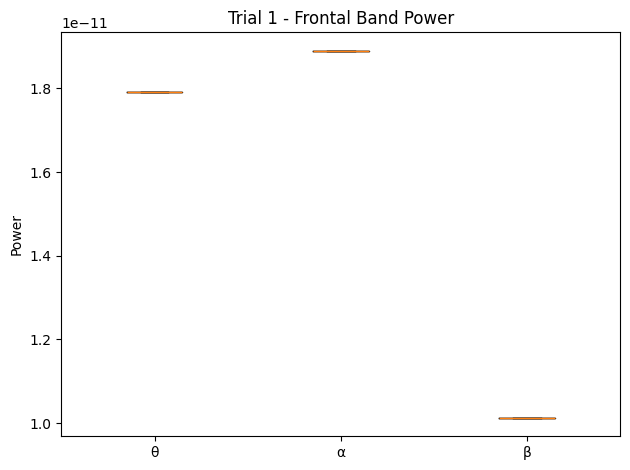

/tmp/ipykernel_1288/2769241438.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


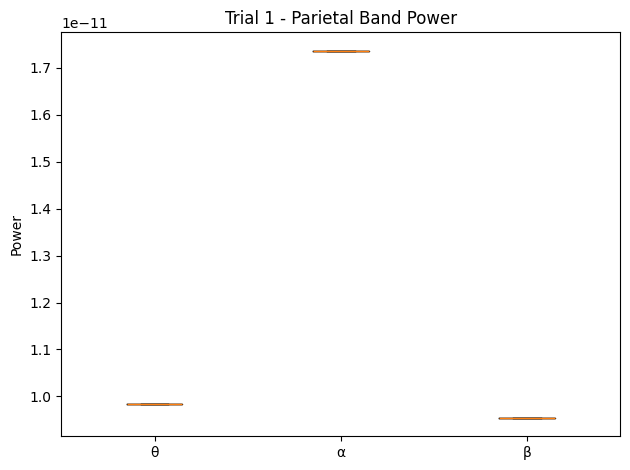

/tmp/ipykernel_1288/2769241438.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


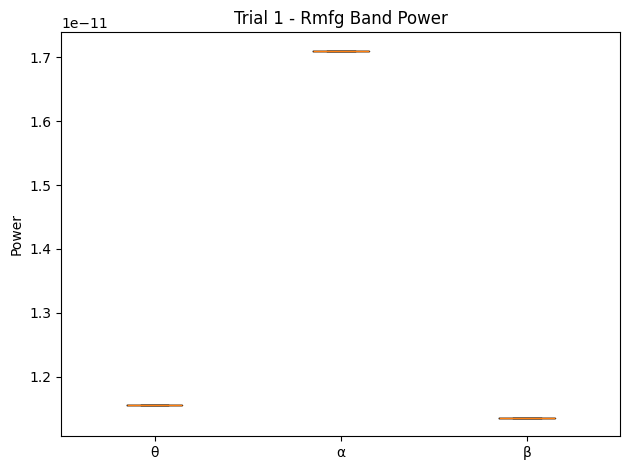

/tmp/ipykernel_1288/2769241438.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


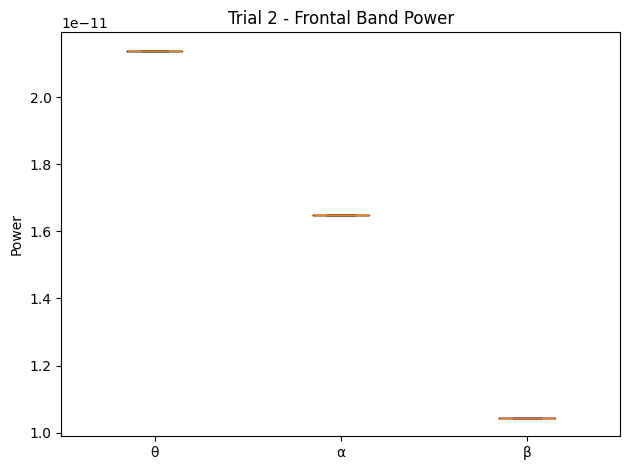

/tmp/ipykernel_1288/2769241438.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


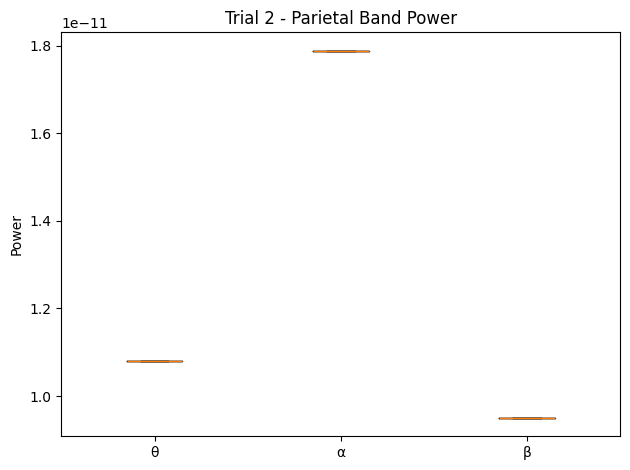

/tmp/ipykernel_1288/2769241438.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


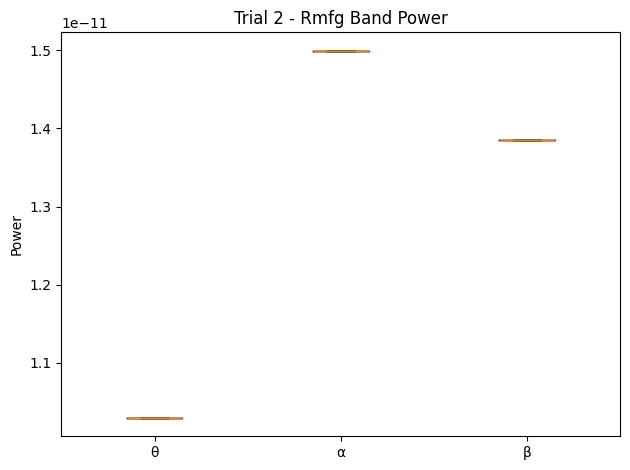

/tmp/ipykernel_1288/2769241438.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


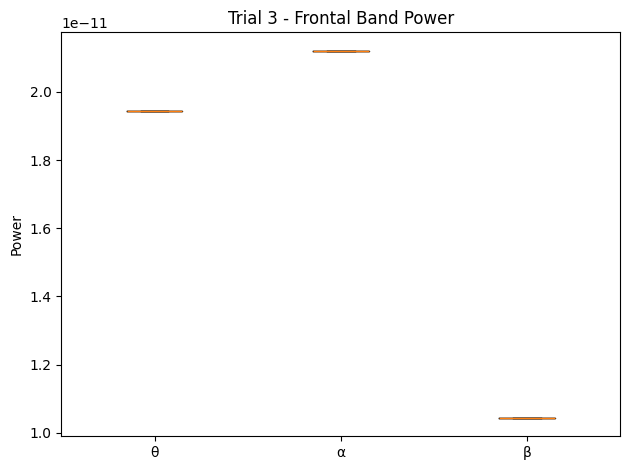

/tmp/ipykernel_1288/2769241438.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


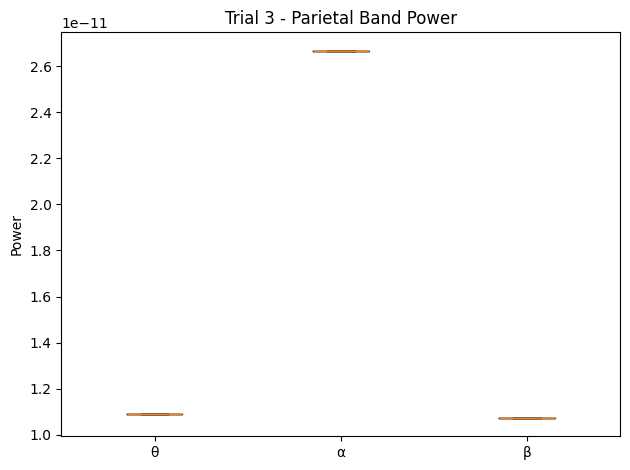

/tmp/ipykernel_1288/2769241438.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


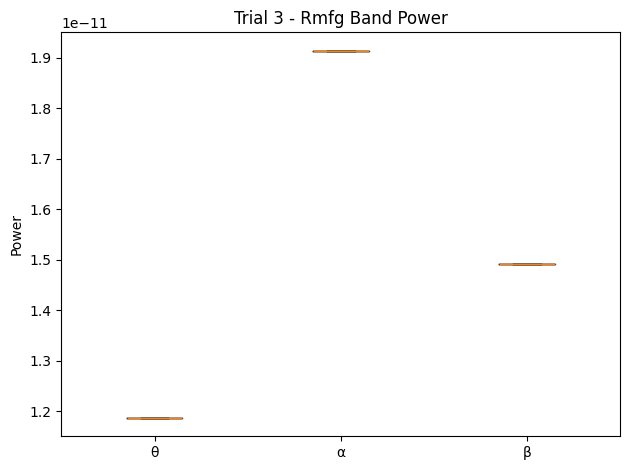

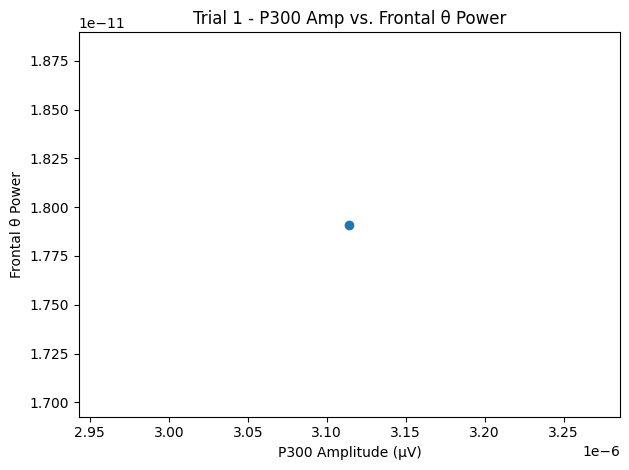

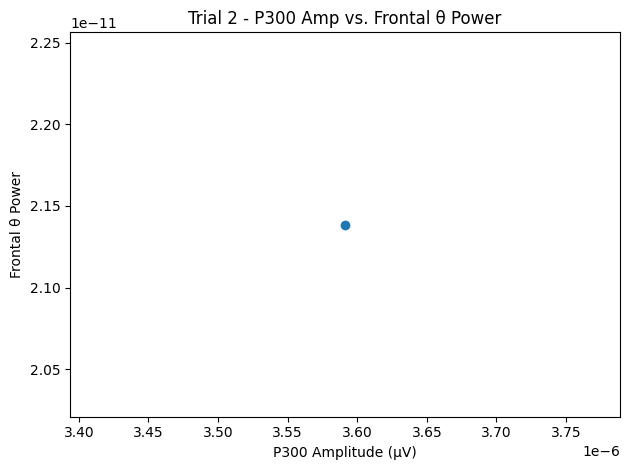

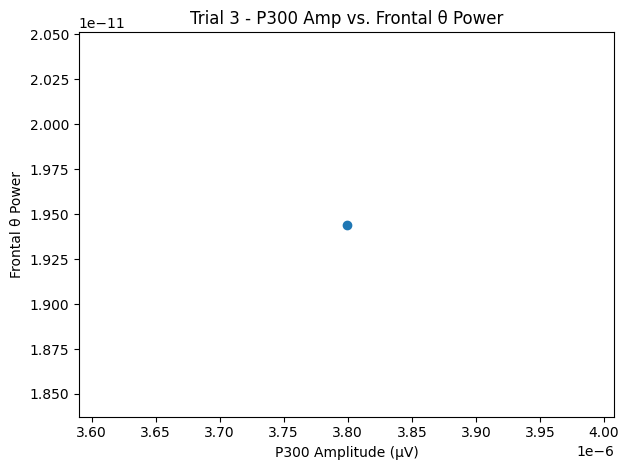

In [14]:
# Band power and p300 average for each trial

# Visualization
import matplotlib.pyplot as plt
import numpy as np

# A) Boxplots of band power per ROI and trial
for trial_num in [1, 2, 3]:
    trial_data = df_trial[df_trial["trial"] == trial_num]
    for roi in trial_data["ROI"].unique():
        fig, ax = plt.subplots()
        roi_data = trial_data[trial_data["ROI"] == roi]
        ax.boxplot(
            [roi_data[roi_data.band == b]["power"] for b in ["theta", "alpha", "beta"]],
            labels=["θ", "α", "β"],
        )
        ax.set_title(f"Trial {trial_num} - {roi.capitalize()} Band Power")
        ax.set_ylabel("Power")
        plt.tight_layout()
        plt.show()

# B) Scatter plots: P300 amplitude vs. frontal theta power for each trial
for trial_num in [1, 2, 3]:
    trial_data = df_trial[
        (df_trial["trial"] == trial_num)
        & (df_trial["band"] == "theta")
        & (df_trial["ROI"] == "frontal")
    ]
    fig, ax = plt.subplots()
    ax.scatter(trial_data["P300_amp"], trial_data["power"])

    # Fit and plot a linear regression line
    if len(trial_data) > 1:  # Only fit line if there are enough points
        m, b = np.polyfit(trial_data["P300_amp"], trial_data["power"], 1)
        ax.plot(trial_data["P300_amp"], m * trial_data["P300_amp"] + b, linestyle="--")

    ax.set_title(f"Trial {trial_num} - P300 Amp vs. Frontal θ Power")
    ax.set_xlabel("P300 Amplitude (µV)")
    ax.set_ylabel("Frontal θ Power")
    plt.tight_layout()
    plt.show()

In [15]:
df_trial.head()

subject trial       ROI   band         power  P300_amp  P300_lat
0  group18_fw     1   frontal  theta  1.791124e-11  0.000003     300.0
1  group18_fw     1  parietal  theta  9.847099e-12  0.000003     300.0
2  group18_fw     1      rMFG  theta  1.156414e-11  0.000003     300.0
3  group18_fw     1   frontal  alpha  1.890229e-11  0.000003     300.0
4  group18_fw     1  parietal  alpha  1.735838e-11  0.000003     300.0

In [17]:
# First, ensure we have the band power data in a suitable format

# Define frequency bands and ROIs according to hypothesis
bands = dict(theta=(4, 7), alpha=(8, 13), beta=(15, 30))
picks = {
    "frontal": ["Fz", "F1", "F2"],  # For theta
    "parietal": ["Pz", "P3", "P4"],  # For alpha
    "rMFG": ["F4", "FC4", "AF4"]     # Right middle frontal gyrus for beta
}

# Extract band power for each subject and condition
records = []
for epochs, subj_id in zip(all_epochs, subject_ids):
    sfreq = epochs.info["sfreq"]
    data = epochs.get_data()  # shape: (n_epochs, n_ch, n_times)
    ch_names = epochs.ch_names
    
    for band_name, (fmin, fmax) in bands.items():
        # Band-pass filter
        data_filt = filter_data(
            data, sfreq, l_freq=fmin, h_freq=fmax, 
            filter_length="auto", verbose=False
        )
        
        # Instantaneous power via analytic signal
        analytic = hilbert(data_filt, axis=-1)
        power_inst = np.abs(analytic) ** 2
        
        for roi, ch_list in picks.items():
            ch_idx_s = [ch_names.index(ch) for ch in ch_list if ch in ch_names]
            if not ch_idx_s:
                continue
            # Mean power across epochs, channels, and timepoints
            val = power_inst[:, ch_idx_s, :].mean()
            records.append((subj_id, roi, band_name, val))

# Create DataFrame
df_band = pd.DataFrame(records, columns=["subject", "ROI", "band", "power"])

# Pivot to have ROIs and bands as columns
df_band_wide = df_band.pivot_table(
    index='subject', 
    columns=['ROI', 'band'], 
    values='power'
).reset_index()

# Flatten multi-index columns
df_band_wide.columns = ['_'.join(col).strip() for col in df_band_wide.columns.values]
df_band_wide = df_band_wide.rename(columns={'subject_': 'subject'})

# Merge with survey data
df_combined = pd.merge(df_band_wide, df_survey, on='subject')

/tmp/ipykernel_1288/977286858.py:21: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1288/977286858.py:21: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1288/977286858.py:21: RuntimeWarning: filter_length (221) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1288/977286858.py:21: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1288/977286858.py:21: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt 

In [18]:
import seaborn as sns
from scipy import stats

# 1. Test for increase in frontal theta with fatigue indicators
print("Frontal theta vs stress:")
print(stats.pearsonr(df_combined['frontal_theta'], df_combined['stress_level']))

print("\nFrontal theta vs average boredom:")
print(stats.pearsonr(df_combined['frontal_theta'], df_combined['avg_boredom']))

print("\nFrontal theta vs sleep hours:")
print(stats.pearsonr(df_combined['frontal_theta'], df_combined['sleep_hours']))

# 2. Test for increase in parietal alpha with fatigue indicators
print("\nParietal alpha vs stress:")
print(stats.pearsonr(df_combined['parietal_alpha'], df_combined['stress_level']))

print("\nParietal alpha vs average boredom:")
print(stats.pearsonr(df_combined['parietal_alpha'], df_combined['avg_boredom']))

print("\nParietal alpha vs sleep hours:")
print(stats.pearsonr(df_combined['parietal_alpha'], df_combined['sleep_hours']))

# 3. Test for decrease in rMFG beta with fatigue indicators
print("\nrMFG beta vs stress:")
print(stats.pearsonr(df_combined['rMFG_beta'], df_combined['stress_level']))

print("\nrMFG beta vs average boredom:")
print(stats.pearsonr(df_combined['rMFG_beta'], df_combined['avg_boredom']))

print("\nrMFG beta vs sleep hours:")
print(stats.pearsonr(df_combined['rMFG_beta'], df_combined['sleep_hours']))

Frontal theta vs stress:
PearsonRResult(statistic=np.float64(0.49458124168637607), pvalue=np.float64(0.6706428807546883))

Frontal theta vs average boredom:
PearsonRResult(statistic=np.float64(0.8628856209468329), pvalue=np.float64(0.3373095474213543))

Frontal theta vs sleep hours:
PearsonRResult(statistic=np.float64(-0.7518253775282168), pvalue=np.float64(0.45834726574503115))

Parietal alpha vs stress:
PearsonRResult(statistic=np.float64(0.17722299111656187), pvalue=np.float64(0.8865772390135046))

Parietal alpha vs average boredom:
PearsonRResult(statistic=np.float64(0.645564973791571), pvalue=np.float64(0.553243905680171))

Parietal alpha vs sleep hours:
PearsonRResult(statistic=np.float64(-0.48960547421564105), pvalue=np.float64(0.6742816240038481))

rMFG beta vs stress:
PearsonRResult(statistic=np.float64(0.8479905558250072), pvalue=np.float64(0.35562467576515233))

rMFG beta vs average boredom:
PearsonRResult(statistic=np.float64(0.9993870319585869), pvalue=np.float64(0.0222913

In [ ]:
# Visualizations
# Set up the figure
plt.figure(figsize=(15, 10))

# 1. Frontal theta relationships
plt.subplot(3, 3, 1)
sns.regplot(x='stress_level', y='frontal_theta', data=df_combined)
plt.title('Frontal Theta vs Stress')

plt.subplot(3, 3, 2)
sns.regplot(x='avg_boredom', y='frontal_theta', data=df_combined)
plt.title('Frontal Theta vs Boredom')

plt.subplot(3, 3, 3)
sns.regplot(x='sleep_hours', y='frontal_theta', data=df_combined)
plt.title('Frontal Theta vs Sleep Hours')

# 2. Parietal alpha relationships
plt.subplot(3, 3, 4)
sns.regplot(x='stress_level', y='parietal_alpha', data=df_combined)
plt.title('Parietal Alpha vs Stress')

plt.subplot(3, 3, 5)
sns.regplot(x='avg_boredom', y='parietal_alpha', data=df_combined)
plt.title('Parietal Alpha vs Boredom')

plt.subplot(3, 3, 6)
sns.regplot(x='sleep_hours', y='parietal_alpha', data=df_combined)
plt.title('Parietal Alpha vs Sleep Hours')

# 3. rMFG beta relationships
plt.subplot(3, 3, 7)
sns.regplot(x='stress_level', y='rMFG_beta', data=df_combined)
plt.title('rMFG Beta vs Stress')

plt.subplot(3, 3, 8)
sns.regplot(x='avg_boredom', y='rMFG_beta', data=df_combined)
plt.title('rMFG Beta vs Boredom')

plt.subplot(3, 3, 9)
sns.regplot(x='sleep_hours', y='rMFG_beta', data=df_combined)
plt.title('rMFG Beta vs Sleep Hours')

plt.tight_layout()
plt.show()

P300 amplitude vs wakeup hour:
PearsonRResult(statistic=np.float64(0.9938272783915669), pvalue=np.float64(0.07077129093030085))

P300 amplitude vs sleep hours:
PearsonRResult(statistic=np.float64(-0.6762051473216916), pvalue=np.float64(0.5272465902343366))

P300 latency vs wakeup hour:
PearsonRResult(statistic=np.float64(-0.22095560135182393), pvalue=np.float64(0.8581648194576429))

P300 latency vs sleep hours:
PearsonRResult(statistic=np.float64(0.9176629354822472), pvalue=np.float64(0.2601469382930058))


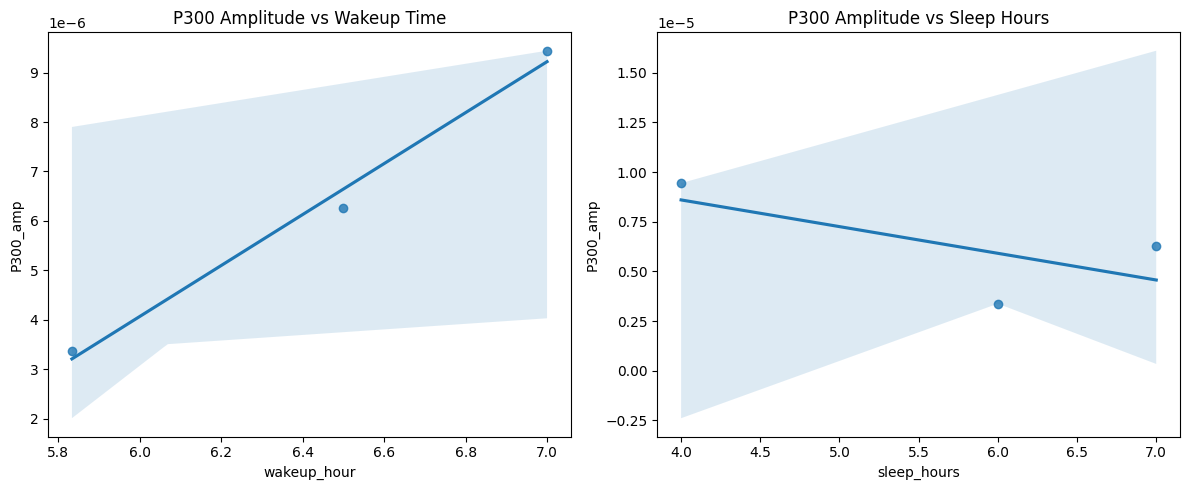

In [19]:
# P300 Analysis Related to Circadian Rhythms

# Extract P300 amplitudes and latencies
p300_records = []
for epochs, subj_id in zip(all_epochs, subject_ids):
    evoked = epochs["Image"].average()  # Using Image condition as in your code
    data_pz = evoked.data[evoked.ch_names.index("Pz")]
    times = evoked.times * 1e3  # convert to ms

    # Define P300 window: 250-500 ms
    mask = (times >= 250) & (times <= 500)
    amp = data_pz[mask].max()  # peak amplitude
    lat = times[mask][data_pz[mask].argmax()]  # peak latency

    p300_records.append((subj_id, amp, lat))

df_p300 = pd.DataFrame(p300_records, columns=["subject", "P300_amp", "P300_lat"])

# Merge with survey data
df_combined = pd.merge(df_combined, df_p300, on='subject')

# Analyze P300 relationships with circadian factors
print("P300 amplitude vs wakeup hour:")
print(stats.pearsonr(df_combined['P300_amp'], df_combined['wakeup_hour']))

print("\nP300 amplitude vs sleep hours:")
print(stats.pearsonr(df_combined['P300_amp'], df_combined['sleep_hours']))

print("\nP300 latency vs wakeup hour:")
print(stats.pearsonr(df_combined['P300_lat'], df_combined['wakeup_hour']))

print("\nP300 latency vs sleep hours:")
print(stats.pearsonr(df_combined['P300_lat'], df_combined['sleep_hours']))

# Visualize these relationships
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.regplot(x='wakeup_hour', y='P300_amp', data=df_combined)
plt.title('P300 Amplitude vs Wakeup Time')

plt.subplot(1, 2, 2)
sns.regplot(x='sleep_hours', y='P300_amp', data=df_combined)
plt.title('P300 Amplitude vs Sleep Hours')

plt.tight_layout()
plt.show()

Replacing existing metadata with 1 columns


/tmp/ipykernel_1288/3042007367.py:49: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1288/3042007367.py:49: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1288/3042007367.py:49: RuntimeWarning: filter_length (221) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1288/3042007367.py:49: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1288/3042007367.py:49: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_

Replacing existing metadata with 1 columns


/tmp/ipykernel_1288/3042007367.py:49: RuntimeWarning: filter_length (221) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1288/3042007367.py:49: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1288/3042007367.py:49: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1288/3042007367.py:49: RuntimeWarning: filter_length (221) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1288/3042007367.py:49: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_

Replacing existing metadata with 1 columns


/tmp/ipykernel_1288/3042007367.py:49: RuntimeWarning: filter_length (221) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1288/3042007367.py:49: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1288/3042007367.py:49: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1288/3042007367.py:49: RuntimeWarning: filter_length (221) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_filt = filter_data(
/tmp/ipykernel_1288/3042007367.py:49: RuntimeWarning: filter_length (413) is longer than the signal (200), distortion is likely. Reduce filter length or filter a longer signal.
  data_

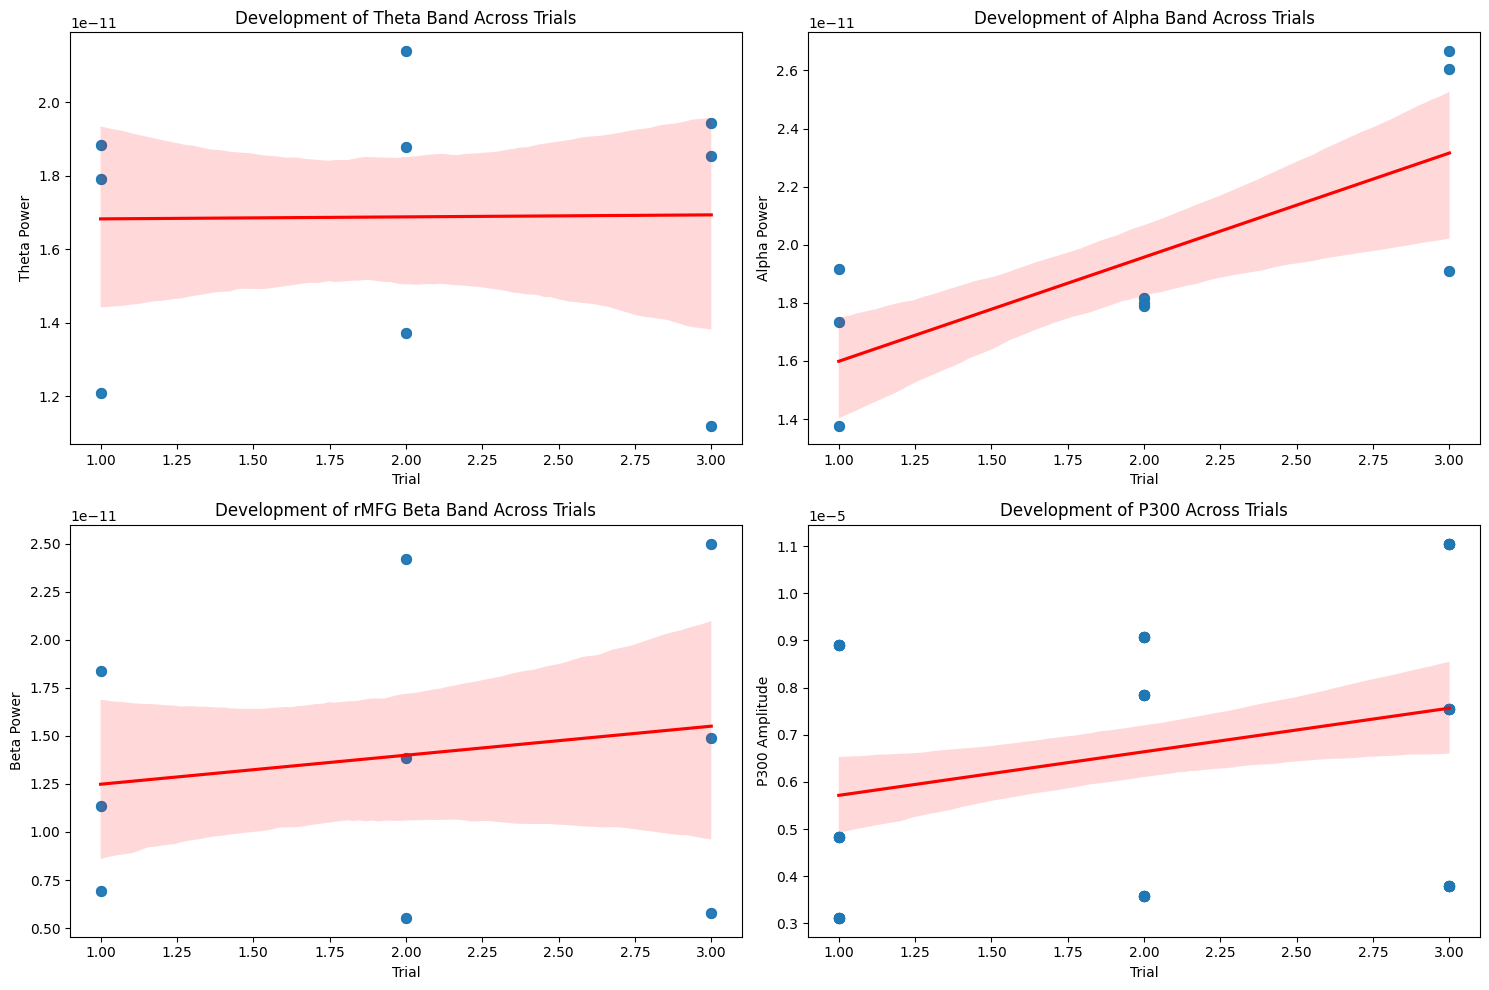

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.signal import hilbert
from mne.filter import filter_data 

n_trials = 3
detailed_records = []

# Define frequency bands and ROIs according to hypothesis
bands = dict(theta=(4, 7), alpha=(8, 13), beta=(15, 30))
picks = {
    "frontal": ["Fz", "F1", "F2"],  # For theta
    "parietal": ["Pz", "P3", "P4"],  # For alpha
    "rMFG": ["F4", "FC4", "AF4"]     # Right middle frontal gyrus for beta
}

# Data processing
for i, (epochs, subj_id) in enumerate(zip(all_epochs, subject_ids)):
    n_events = len(epochs.events)
    trial_len = n_events // n_trials
    
    # Create trial labels
    trial_labels = np.repeat(np.arange(1, n_trials + 1), trial_len)
    if len(trial_labels) < n_events:
        trial_labels = np.concatenate(
            [trial_labels, [n_trials] * (n_events - len(trial_labels))]
        )
    
    # Assign metadata
    metadata = pd.DataFrame({'trial': trial_labels})
    epochs.metadata = metadata
    
    # Process each trial separately
    image_epochs = epochs["Image"].copy()
    
    for trial_num in [1, 2, 3]:
        trial_mask = image_epochs.metadata["trial"] == trial_num
        trial_epochs = image_epochs[trial_mask]
        
        # Skip if no epochs in this trial
        if len(trial_epochs) == 0:
            continue
            
        # Compute band power for this trial
        for band_name, (fmin, fmax) in bands.items():
            data_filt = filter_data(
                trial_epochs.get_data(),
                trial_epochs.info["sfreq"],
                l_freq=fmin,
                h_freq=fmax,
                filter_length="auto",
                verbose=False,
            )
            analytic = hilbert(data_filt, axis=-1)
            power_inst = np.abs(analytic) ** 2
            
            for roi, ch_list in picks.items():
                ch_idx_s = [trial_epochs.ch_names.index(ch) 
                           for ch in ch_list if ch in trial_epochs.ch_names]
                if ch_idx_s:
                    val = power_inst[:, ch_idx_s, :].mean()
                    detailed_records.append((subj_id, trial_num, roi, band_name, val))
        
        # Compute P300 for this trial
        evoked = trial_epochs.average()
        data_pz = evoked.data[evoked.ch_names.index("Pz")]
        times = evoked.times * 1e3
        mask = (times >= 250) & (times <= 500)
        p300_amp = data_pz[mask].max()
        
        # Append P300 amplitude for all band/ROI combinations of this trial
        for record in detailed_records[-len(bands)*len(picks):]:
            detailed_records.append(record + (p300_amp,))

# Create DataFrame from detailed records
columns = ["subject", "trial", "roi", "band", "power", "P300_amp"]
df_trial_detail = pd.DataFrame(detailed_records, columns=columns)

# Merge with survey data
df_trial_full = pd.merge(df_trial_detail, df_survey, on='subject')

# Plot Development of Each Band Power Across Trials with Linear Regression

# Set up the plot grid
plt.figure(figsize=(15, 10))

# 1) Development of Theta band across trials
plt.subplot(2, 2, 1)
df_theta = df_trial_full[(df_trial_full['roi']=='frontal') & (df_trial_full['band']=='theta')]
sns.regplot(x='trial', y='power', data=df_theta, scatter_kws={'s': 50}, line_kws={"color": "red"})
plt.title('Development of Theta Band Across Trials')
plt.xlabel('Trial')
plt.ylabel('Theta Power')

# 2) Development of Alpha band across trials
plt.subplot(2, 2, 2)
df_alpha = df_trial_full[(df_trial_full['roi']=='parietal') & (df_trial_full['band']=='alpha')]
sns.regplot(x='trial', y='power', data=df_alpha, scatter_kws={'s': 50}, line_kws={"color": "red"})
plt.title('Development of Alpha Band Across Trials')
plt.xlabel('Trial')
plt.ylabel('Alpha Power')

# 3) Development of rMFG Beta band across trials
plt.subplot(2, 2, 3)
df_beta = df_trial_full[(df_trial_full['roi']=='rMFG') & (df_trial_full['band']=='beta')]
sns.regplot(x='trial', y='power', data=df_beta, scatter_kws={'s': 50}, line_kws={"color": "red"})
plt.title('Development of rMFG Beta Band Across Trials')
plt.xlabel('Trial')
plt.ylabel('Beta Power')

# 4) Development of P300 across trials
plt.subplot(2, 2, 4)
sns.regplot(x='trial', y='P300_amp', data=df_trial_full, scatter_kws={'s': 50}, line_kws={"color": "red"})
plt.title('Development of P300 Across Trials')
plt.xlabel('Trial')
plt.ylabel('P300 Amplitude')

# Show the plots
plt.tight_layout()
plt.show()


Correlation with Stress Level:
Theta: 0.807114878018401
Alpha: 0.3619688513927373
Beta: 0.9105832969573358

Correlation with Average Boredom:
Theta: 0.9941791992009434
Alpha: 0.7795693157623407
Beta: 0.995251072076293

Correlation with Sleep Hours:
Theta: -0.9559038116265465
Alpha: -0.6471592802975337
Beta: -0.9957129035762791

Correlation of P300 Amplitude with Circadian Rhythm:
Wakeup Hour: 0.9985616011084536
Sleep Hours: -0.6327305144065879


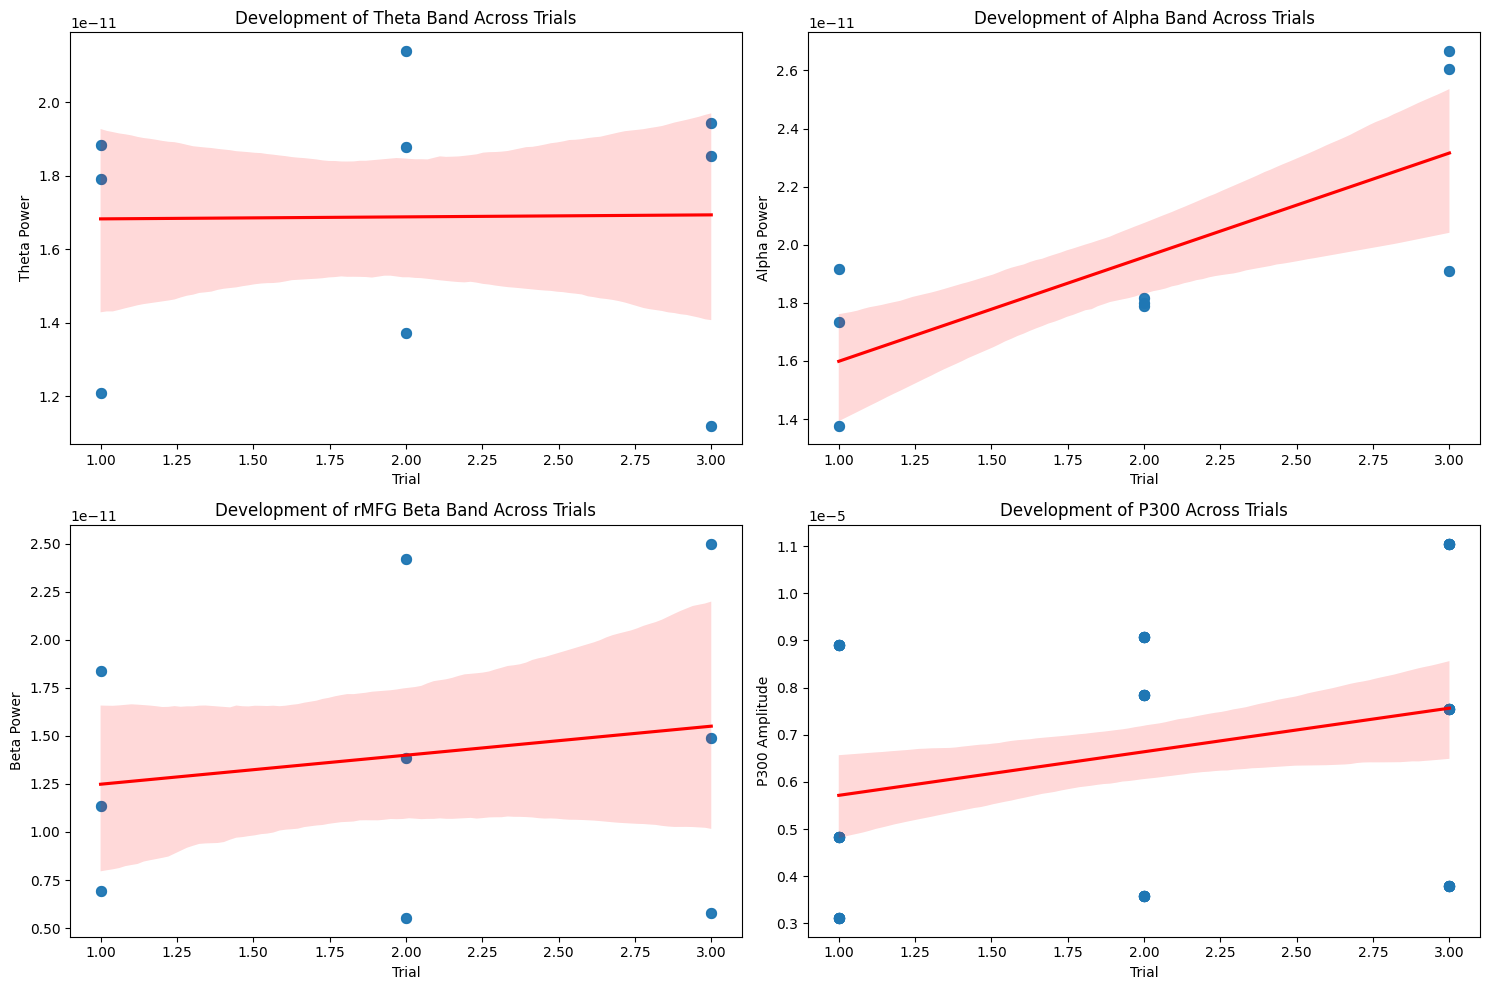

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.signal import hilbert
from mne.filter import filter_data

n_trials = 3
detailed_records = []

# Define frequency bands and ROIs according to hypothesis
bands = dict(theta=(4, 7), alpha=(8, 13), beta=(15, 30))
picks = {
    "frontal": ["Fz", "F1", "F2"],  # For theta
    "parietal": ["Pz", "P3", "P4"],  # For alpha
    "rMFG": ["F4", "FC4", "AF4"]     # Right middle frontal gyrus for beta
}
# Statistical tests and interpretation

# Test correlations with stress level
theta_corr_stress = df_trial_full[df_trial_full['band'] == 'theta'].groupby('subject')['power'].mean().corr(df_trial_full.groupby('subject')['stress_level'].mean())
alpha_corr_stress = df_trial_full[df_trial_full['band'] == 'alpha'].groupby('subject')['power'].mean().corr(df_trial_full.groupby('subject')['stress_level'].mean())
beta_corr_stress = df_trial_full[df_trial_full['band'] == 'beta'].groupby('subject')['power'].mean().corr(df_trial_full.groupby('subject')['stress_level'].mean())

# Test correlations with avg boredom
theta_corr_boredom = df_trial_full[df_trial_full['band'] == 'theta'].groupby('subject')['power'].mean().corr(df_trial_full.groupby('subject')['avg_boredom'].mean())
alpha_corr_boredom = df_trial_full[df_trial_full['band'] == 'alpha'].groupby('subject')['power'].mean().corr(df_trial_full.groupby('subject')['avg_boredom'].mean())
beta_corr_boredom = df_trial_full[df_trial_full['band'] == 'beta'].groupby('subject')['power'].mean().corr(df_trial_full.groupby('subject')['avg_boredom'].mean())

# Test correlations with sleep hours
theta_corr_sleep_hours = df_trial_full[df_trial_full['band'] == 'theta'].groupby('subject')['power'].mean().corr(df_trial_full.groupby('subject')['sleep_hours'].mean())
alpha_corr_sleep_hours = df_trial_full[df_trial_full['band'] == 'alpha'].groupby('subject')['power'].mean().corr(df_trial_full.groupby('subject')['sleep_hours'].mean())
beta_corr_sleep_hours = df_trial_full[df_trial_full['band'] == 'beta'].groupby('subject')['power'].mean().corr(df_trial_full.groupby('subject')['sleep_hours'].mean())

# Test correlations with wakeup hour (circadian rhythm)
p300_corr_wakeup_hour = df_trial_full.groupby('subject')['P300_amp'].mean().corr(df_trial_full.groupby('subject')['wakeup_hour'].mean())
p300_corr_sleep_hours = df_trial_full.groupby('subject')['P300_amp'].mean().corr(df_trial_full.groupby('subject')['sleep_hours'].mean())

# Print correlation results
print("Correlation with Stress Level:")
print(f"Theta: {theta_corr_stress}")
print(f"Alpha: {alpha_corr_stress}")
print(f"Beta: {beta_corr_stress}")

print("\nCorrelation with Average Boredom:")
print(f"Theta: {theta_corr_boredom}")
print(f"Alpha: {alpha_corr_boredom}")
print(f"Beta: {beta_corr_boredom}")

print("\nCorrelation with Sleep Hours:")
print(f"Theta: {theta_corr_sleep_hours}")
print(f"Alpha: {alpha_corr_sleep_hours}")
print(f"Beta: {beta_corr_sleep_hours}")

print("\nCorrelation of P300 Amplitude with Circadian Rhythm:")
print(f"Wakeup Hour: {p300_corr_wakeup_hour}")
print(f"Sleep Hours: {p300_corr_sleep_hours}")

# Plot Development of Each Band Power Across Trials with Linear Regression

# Set up the plot grid
plt.figure(figsize=(15, 10))

# 1) Development of Theta band across trials
plt.subplot(2, 2, 1)
df_theta = df_trial_full[(df_trial_full['roi']=='frontal') & (df_trial_full['band']=='theta')]
sns.regplot(x='trial', y='power', data=df_theta, scatter_kws={'s': 50}, line_kws={"color": "red"})
plt.title('Development of Theta Band Across Trials')
plt.xlabel('Trial')
plt.ylabel('Theta Power')

# 2) Development of Alpha band across trials
plt.subplot(2, 2, 2)
df_alpha = df_trial_full[(df_trial_full['roi']=='parietal') & (df_trial_full['band']=='alpha')]
sns.regplot(x='trial', y='power', data=df_alpha, scatter_kws={'s': 50}, line_kws={"color": "red"})
plt.title('Development of Alpha Band Across Trials')
plt.xlabel('Trial')
plt.ylabel('Alpha Power')

# 3) Development of rMFG Beta band across trials
plt.subplot(2, 2, 3)
df_beta = df_trial_full[(df_trial_full['roi']=='rMFG') & (df_trial_full['band']=='beta')]
sns.regplot(x='trial', y='power', data=df_beta, scatter_kws={'s': 50}, line_kws={"color": "red"})
plt.title('Development of rMFG Beta Band Across Trials')
plt.xlabel('Trial')
plt.ylabel('Beta Power')

# 4) Development of P300 across trials
plt.subplot(2, 2, 4)
sns.regplot(x='trial', y='P300_amp', data=df_trial_full, scatter_kws={'s': 50}, line_kws={"color": "red"})
plt.title('Development of P300 Across Trials')
plt.xlabel('Trial')
plt.ylabel('P300 Amplitude')

# Show the plots
plt.tight_layout()
plt.show()

Processing subject: group0-fw2
Partial channels for frontal in group0-fw2: using ['Fz']
Error in group0-fw2 event 0 frontal-theta: The requested filter length 199 is too short for the requested 1.00 Hz transition band, which requires 413 samples
Error in group0-fw2 event 0 frontal-alpha: The requested filter length 199 is too short for the requested 1.63 Hz transition band, which requires 255 samples
Error in group0-fw2 event 0 frontal-beta: The requested filter length 199 is too short for the requested 1.88 Hz transition band, which requires 221 samples
Error in group0-fw2 event 0 parietal-theta: The requested filter length 199 is too short for the requested 1.00 Hz transition band, which requires 413 samples
Error in group0-fw2 event 0 parietal-alpha: The requested filter length 199 is too short for the requested 1.63 Hz transition band, which requires 255 samples
Error in group0-fw2 event 0 parietal-beta: The requested filter length 199 is too short for the requested 1.88 Hz transit

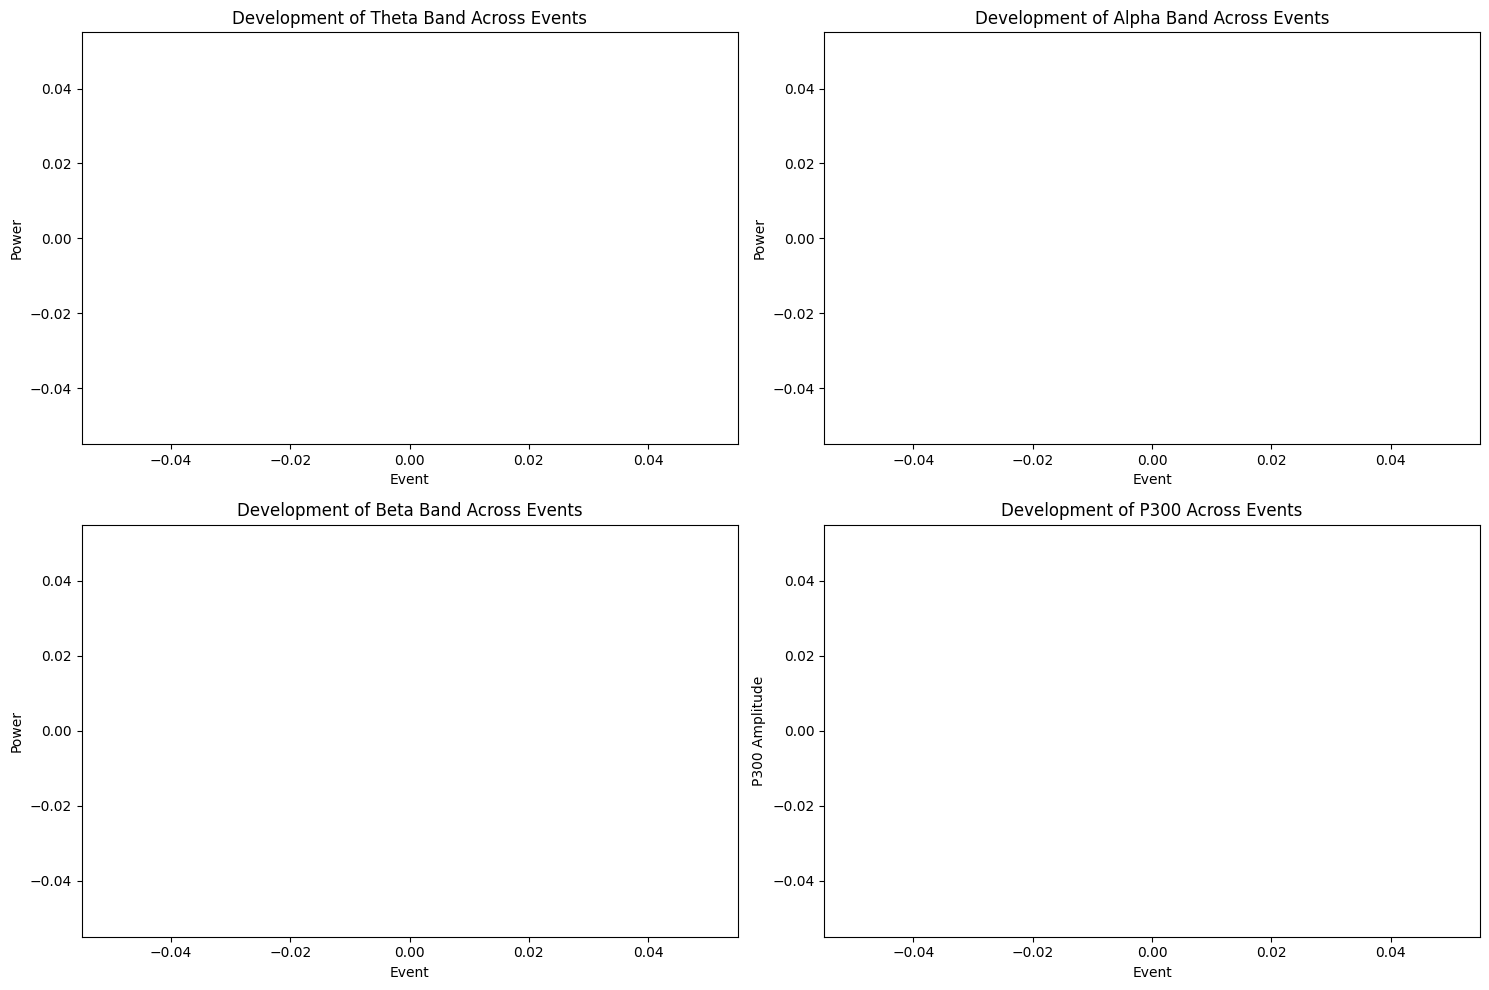

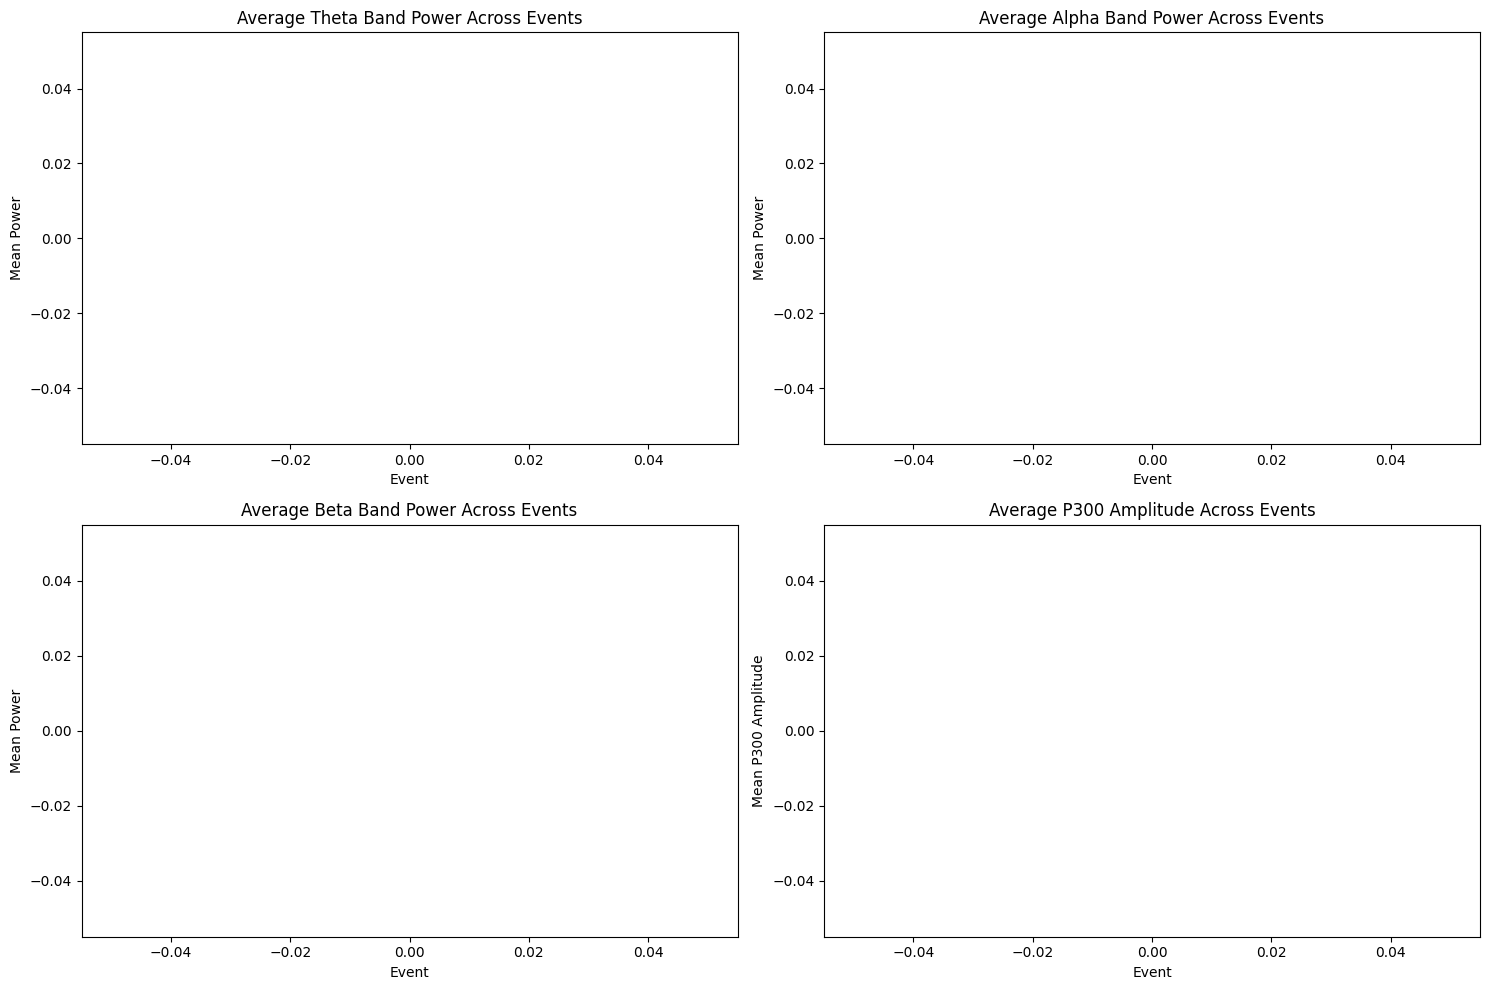

In [17]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import hilbert
from mne.filter import filter_data

# Suppress specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, 
                        message="filter_length .* is longer than the signal")

# === Preprocessing survey data ===

# Exclude problematic groups
df_survey = df_survey[~df_survey['subject'].isin(['group2_fw', 'group6_fw'])]

# Extract hour from wakeup time string
df_survey['wakeup_hour'] = df_survey['wakeup_time'].apply(lambda x: int(x.split(':')[0]) + int(x.split(':')[1]) / 60)

# Compute average boredom
df_survey['avg_boredom'] = df_survey[['boredom_trial1', 'boredom_trial2', 'boredom_trial3']].mean(axis=1)

# === EEG frequency bands and ROIs ===

bands = dict(theta=(4, 7), alpha=(8, 13), beta=(15, 30))
picks = {
    "frontal": ["Fz", "F1", "F2"],      # Theta band
    "parietal": ["Pz", "P3", "P4"],     # Alpha band
    "rMFG": ["F4", "FC4", "AF4"]        # Beta band
}
p300_channel = 'Pz'
p300_window = (0.3, 0.6)  # In seconds

# === Feature extraction loop ===

detailed_records = []

for subj_epochs in all_epochs:
    # Get subject ID from filename
    subject = subj_epochs.filename.split('/')[-1].replace('-epo.fif', '')
    print(f"Processing subject: {subject}")
    
    sfreq = subj_epochs.info['sfreq']
    tmin = subj_epochs.times[0]
    p300_start_idx = int((p300_window[0] - tmin) * sfreq)
    p300_end_idx = int((p300_window[1] - tmin) * sfreq)
    signal_length = subj_epochs.get_data().shape[2]  # Number of time points
    
    # Calculate appropriate filter length (must be less than signal length)
    filter_len = min(int(sfreq * 1.0), signal_length - 1)  # 1 second or max possible
    
    for i, event in enumerate(subj_epochs.events):
        for roi_name, roi_channels in picks.items():
            # Get available channels for this ROI
            available_channels = [ch for ch in roi_channels if ch in subj_epochs.ch_names]
            
            if not available_channels:
                print(f"Skipping ROI {roi_name} for subject {subject} — no available channels")
                continue
            elif len(available_channels) < len(roi_channels):
                print(f"Partial channels for {roi_name} in {subject}: using {available_channels}")

            for band_name, (fmin, fmax) in bands.items():
                try:
                    # Get data for this event and ROI channels
                    data = subj_epochs.copy().pick(available_channels).get_data()[i]
                    
                    # Filter and compute power with adjusted filter length
                    filtered = filter_data(data, sfreq=sfreq, l_freq=fmin, h_freq=fmax, 
                                         filter_length=filter_len, verbose=False)
                    power = np.mean(np.abs(hilbert(filtered, axis=1)) ** 2)

                    # Get P300 amplitude
                    ch_data = subj_epochs.copy().pick([p300_channel]).get_data()[i][0]
                    P300_amp = np.max(ch_data[p300_start_idx:p300_end_idx])

                    detailed_records.append([subject, i, roi_name, band_name, power, P300_amp])
                except Exception as e:
                    print(f"Error in {subject} event {i} {roi_name}-{band_name}: {e}")

# === Combine and analyze results ===

columns = ["subject", "event", "roi", "band", "power", "P300_amp"]
df_event_detail = pd.DataFrame(detailed_records, columns=columns)
df_event_full = pd.merge(df_event_detail, df_survey, on='subject')

# === Analysis Functions ===

def compute_band_corr(band, var):
    """Compute correlation between band power and survey variable"""
    band_data = df_event_full[df_event_full['band'] == band].groupby('subject')['power'].mean()
    survey_data = df_event_full.groupby('subject')[var].mean()
    return band_data.corr(survey_data)

def print_correlations(var_name):
    """Print correlations for all bands with a given variable"""
    print(f"\nCorrelation with {var_name}:")
    for band in bands.keys():
        corr = compute_band_corr(band, var_name)
        print(f"{band.capitalize()}: {corr:.3f}")

# Print correlations for different survey measures
print_correlations('stress_level')
print_correlations('avg_boredom')
print_correlations('sleep_hours')

# P300 correlations with circadian measures
p300_corr_wakeup_hour = df_event_full.groupby('subject')['P300_amp'].mean().corr(
    df_event_full.groupby('subject')['wakeup_hour'].mean())
p300_corr_sleep_hours = df_event_full.groupby('subject')['P300_amp'].mean().corr(
    df_event_full.groupby('subject')['sleep_hours'].mean())

print("\nCorrelation of P300 Amplitude with Circadian Rhythm:")
print(f"Wakeup Hour: {p300_corr_wakeup_hour:.3f}")
print(f"Sleep Hours: {p300_corr_sleep_hours:.3f}")

# === Prepare data for plotting ===

# Create filtered DataFrames for each band
df_theta = df_event_full[(df_event_full['roi'] == 'frontal') & (df_event_full['band'] == 'theta')]
df_alpha = df_event_full[(df_event_full['roi'] == 'parietal') & (df_event_full['band'] == 'alpha')]
df_beta = df_event_full[(df_event_full['roi'] == 'rMFG') & (df_event_full['band'] == 'beta')]

# Compute averages per event
df_theta_avg = df_theta.groupby('event', as_index=False)['power'].mean()
df_alpha_avg = df_alpha.groupby('event', as_index=False)['power'].mean()
df_beta_avg = df_beta.groupby('event', as_index=False)['power'].mean()
df_p300_avg = df_event_full.groupby('event', as_index=False)['P300_amp'].mean()

# === Plotting Functions ===

def plot_band_development(df, title, ax):
    """Plot band power development across events"""
    sns.regplot(x='event', y='power', data=df, 
                scatter_kws={'s': 50, 'alpha': 0.5}, 
                line_kws={"color": "red"},
                ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Event')
    ax.set_ylabel('Power')

def plot_avg_development(df, title, ax):
    """Plot average band power development across events"""
    sns.regplot(x='event', y='power', data=df, 
                scatter_kws={'s': 80, 'color': 'blue'}, 
                line_kws={"color": "red"},
                ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Event')
    ax.set_ylabel('Mean Power')

# === Create Plots ===

# Plot 1: Individual band development
fig1, axes1 = plt.subplots(2, 2, figsize=(15, 10))
plot_band_development(df_theta, 'Development of Theta Band Across Events', axes1[0, 0])
plot_band_development(df_alpha, 'Development of Alpha Band Across Events', axes1[0, 1])
plot_band_development(df_beta, 'Development of Beta Band Across Events', axes1[1, 0])
sns.regplot(x='event', y='P300_amp', data=df_event_full, 
            scatter_kws={'s': 50, 'alpha': 0.5}, 
            line_kws={"color": "red"},
            ax=axes1[1, 1])
axes1[1, 1].set_title('Development of P300 Across Events')
axes1[1, 1].set_xlabel('Event')
axes1[1, 1].set_ylabel('P300 Amplitude')
plt.tight_layout()

# Plot 2: Average band development
fig2, axes2 = plt.subplots(2, 2, figsize=(15, 10))
plot_avg_development(df_theta_avg, 'Average Theta Band Power Across Events', axes2[0, 0])
plot_avg_development(df_alpha_avg, 'Average Alpha Band Power Across Events', axes2[0, 1])
plot_avg_development(df_beta_avg, 'Average Beta Band Power Across Events', axes2[1, 0])
sns.regplot(x='event', y='P300_amp', data=df_p300_avg, 
            scatter_kws={'s': 80, 'color': 'blue'}, 
            line_kws={"color": "red"},
            ax=axes2[1, 1])
axes2[1, 1].set_title('Average P300 Amplitude Across Events')
axes2[1, 1].set_xlabel('Event')
axes2[1, 1].set_ylabel('Mean P300 Amplitude')
plt.tight_layout()

plt.show()

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# For theta power
theta_model = smf.mixedlm("power ~ event", data=df_theta, groups=df_theta["subject"]).fit()
print(theta_model.summary())

# For alpha power
alpha_model = smf.mixedlm("power ~ event", data=df_alpha, groups=df_alpha["subject"]).fit()
print(alpha_model.summary())

# For beta power
beta_model = smf.mixedlm("power ~ event", data=df_beta, groups=df_beta["subject"]).fit()
print(beta_model.summary())

from scipy.stats import pearsonr

def compute_band_corr_with_p(band, var):
    band_means = df_event_full[df_event_full['band'] == band].groupby('subject')['power'].mean()
    var_means = df_event_full.groupby('subject')[var].mean()
    corr, pval = pearsonr(band_means, var_means)
    return corr, pval

# Example usage
theta_stress_corr, theta_stress_p = compute_band_corr_with_p('theta', 'stress_level')
print(f"Theta-Stress correlation: r={theta_stress_corr:.2f}, p={theta_stress_p:.4f}")

# Prepare subject-level data
df_subj = df_event_full.groupby('subject').agg({
    'P300_amp': 'mean',
    'stress_level': 'mean',
    'avg_boredom': 'mean',
    'sleep_hours': 'mean',
    'wakeup_hour': 'mean'
}).reset_index()

# Get mean power for each band and ROI combination
df_power = df_event_full.groupby(['subject', 'roi', 'band'])['power'].mean().reset_index()

# Merge with subject data
df_analysis = pd.merge(df_power, df_subj, on='subject')

# Now run regression for theta in frontal region
theta_lm = smf.ols(
    "power ~ stress_level + avg_boredom + sleep_hours + wakeup_hour",
    data=df_analysis[(df_analysis['roi'] == 'frontal') & (df_analysis['band'] == 'theta')]
).fit()
print(theta_lm.summary())

# For alpha in parietal region
alpha_lm = smf.ols(
    "power ~ stress_level + avg_boredom + sleep_hours + wakeup_hour",
    data=df_analysis[(df_analysis['roi'] == 'parietal') & (df_analysis['band'] == 'alpha')]
).fit()
print(alpha_lm.summary())

# For beta in rMFG region
beta_lm = smf.ols(
    "power ~ stress_level + avg_boredom + sleep_hours + wakeup_hour",
    data=df_analysis[(df_analysis['roi'] == 'rMFG') & (df_analysis['band'] == 'beta')]
).fit()
print(beta_lm.summary())

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import hilbert
from scipy.stats import linregress

detailed_records = []

# Define frequency bands and ROIs according to hypothesis
bands = dict(theta=(4, 7), alpha=(8, 13), beta=(15, 30))
picks = {
    "frontal": ["Fz", "F1", "F2"],  # For theta
    "parietal": ["Pz", "P3", "P4"],  # For alpha
    "rMFG": ["F4", "FC4", "AF4"]     # Right middle frontal gyrus for beta
}

# Statistical tests and interpretation

def test_significance(df, x_col, y_col):
    slope, intercept, r_value, p_value, std_err = linregress(df[x_col], df[y_col])
    return p_value

# Test significance of changes over events for each plot

# Theta band across events
df_theta = df_event_full[(df_event_full['roi']=='frontal') & (df_event_full['band']=='theta')]
theta_p_value = test_significance(df_theta, 'event', 'power')

# Alpha band across events
df_alpha = df_event_full[(df_event_full['roi']=='parietal') & (df_event_full['band']=='alpha')]
alpha_p_value = test_significance(df_alpha, 'event', 'power')

# Beta band across events
df_beta = df_event_full[(df_event_full['roi']=='rMFG') & (df_event_full['band']=='beta')]
beta_p_value = test_significance(df_beta, 'event', 'power')

# P300 amplitude across events
p300_p_value = test_significance(df_event_full, 'event', 'P300_amp')

# Print p-values to check significance
print("P-values for significance tests:")
print(f"Theta band: {theta_p_value}")
print(f"Alpha band: {alpha_p_value}")
print(f"Beta band: {beta_p_value}")
print(f"P300 amplitude: {p300_p_value}")

# Plot Development of Each Band Power Across Events with Linear Regression

# Set up the plot grid
plt.figure(figsize=(15, 10))

# 1) Development of Theta band across events
plt.subplot(2, 2, 1)
sns.regplot(x='event', y='power', data=df_theta, scatter_kws={'s': 50}, line_kws={"color": "red"})
plt.title('Development of Theta Band Across Events')
plt.xlabel('Event')
plt.ylabel('Theta Power')

# 2) Development of Alpha band across events
plt.subplot(2, 2, 2)
sns.regplot(x='event', y='power', data=df_alpha, scatter_kws={'s': 50}, line_kws={"color": "red"})
plt.title('Development of Alpha Band Across Events')
plt.xlabel('Event')
plt.ylabel('Alpha Power')

# 3) Development of rMFG Beta band across events
plt.subplot(2, 2, 3)
sns.regplot(x='event', y='power', data=df_beta, scatter_kws={'s': 50}, line_kws={"color": "red"})
plt.title('Development of rMFG Beta Band Across Events')
plt.xlabel('Event')
plt.ylabel('Beta Power')

# 4) Development of P300 across events
plt.subplot(2, 2, 4)
sns.regplot(x='event', y='P300_amp', data=df_event_full, scatter_kws={'s': 50}, line_kws={"color": "red"})
plt.title('Development of P300 Across Events')
plt.xlabel('Event')
plt.ylabel('P300 Amplitude')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM

# Example for frontal-theta
df_rm_theta = df_event_full[(df_event_full['roi']=='frontal') & (df_event_full['band']=='theta')]

anova_theta = AnovaRM(df_rm_theta, depvar='power', subject='subject', within=['event']).fit()
print(anova_theta)

from scipy.stats import friedmanchisquare

# Pivot data: rows = subjects, columns = events
df_friedman = df_event_full[(df_event_full['roi']=='rMFG') & (df_event_full['band']=='beta')]
pivot = df_friedman.pivot(index='subject', columns='event', values='power')

# Run test
stat, p = friedmanchisquare(*[pivot[col] for col in pivot.columns])
print("Friedman test p-value (rMFG-beta):", p)

# Example: add quadratic term for theta band
df_theta['event_squared'] = df_theta['event']**2
model = smf.ols("power ~ event + event_squared", data=df_theta).fit()
print(model.summary())

bands_rois = {
    'theta': 'frontal',
    'alpha': 'parietal',
    'beta': 'rMFG'
}

for band, roi in bands_rois.items():
    df_sub = df_event_full[(df_event_full['band'] == band) & (df_event_full['roi'] == roi)]
    model = smf.mixedlm("power ~ event", df_sub, groups=df_sub["subject"])
    result = model.fit()
    print(f"\nLME for {band}-{roi}:\n", result.summary())

In [ ]:
# Time-course plot with error bands
plt.figure(figsize=(12,6))
for band, roi in [('theta', 'frontal'), ('alpha', 'parietal'), ('beta', 'rMFG')]:
    subset = df_trial_full[(df_trial_full['band']==band) & (df_trial_full['roi']==roi)]
    sns.lineplot(x='trial', y='power', data=subset, 
                 label=f'{roi} {band}', errorbar=('se', 2))
    
plt.title('EEG Power Dynamics Across Trials')
plt.ylabel('Normalized Power')
plt.xticks([1,2,3])
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()

# Categorize by self-reported productive time
df_combined['chronotype'] = df_combined['productive_time'].apply(
    lambda x: 'Morning' if 'morning' in x else 'Evening'
)

# Plot circadian interactions
fig, ax = plt.subplots(1,2,figsize=(14,5))
sns.boxplot(x='chronotype', y='frontal_theta', data=df_combined, ax=ax[0])
ax[0].set_title('Frontal Theta by Chronotype')

sns.regplot(x='wakeup_hour', y='P300_amp', data=df_combined, 
            scatter_kws={'alpha':0.6}, ax=ax[1])
ax[1].set_title('P300 Amplitude vs Wake-up Time')

# Pairwise relationships matrix
g = sns.PairGrid(df_combined[['frontal_theta', 'parietal_alpha', 'rMFG_beta',
                             'stress_level', 'avg_boredom', 'sleep_hours']])
g.map_upper(sns.scatterplot, alpha=0.6)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot, kde=True)
g.fig.suptitle('Fatigue Marker Relationships', y=1.02)

# Sleep x Stress interaction
plt.figure(figsize=(10,6))
sns.lmplot(x='stress_level', y='frontal_theta', hue='sleep_group',
           data=df_combined.assign(
               sleep_group=lambda x: np.where(x['sleep_hours']>7,'>7hrs','≤7hrs')
           ))
plt.title('Stress-Frontal Theta Relationship by Sleep Duration')

In [ ]:
# Statistical testing
from scipy.stats import shapiro

stat, p = shapiro(df_survey['avg_boredom'])
print('Shapiro-Wilk Test: stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print("Data appears normally distributed.")
else:
    print("Data does not appear normally distributed.")

In [ ]:
import statsmodels.api as sm

X = df_survey[['wakeup_hour', 'sleep_hours', 'stress_level']]
X = sm.add_constant(X)
y = df_survey['avg_boredom']

model = sm.OLS(y, X).fit()
print(model.summary())

In [ ]:
# Export the combined survey and EEG data
df_combined.to_csv("eeg_behavior_data.csv", index=False)
print("Data exported to 'eeg_behavior_data.csv'")

# can make statistical tests in R based on this.